# Tutorial 3


*   Analisis Klaster
*   Analisis Asosiasi



## Import libraries

In [1]:
# install yellowbrick to vizualize the Elbow curve
# !pip install yellowbrick    

In [2]:
# install MST (minimum spanning tree) clustering
# !pip install mst_clustering 

In [3]:
# install mlxtend for association rule analysis
# !pip install mlxtend --upgrade
# RESTART runtime after installing

In [4]:
# import library
import pandas as pd
import numpy as np
from numpy import *
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.express as px

# feature extraction using PCA
from sklearn.decomposition import PCA

# import kmeans
from sklearn.cluster import KMeans
# import library for kmeans: elbow curve & silhouette visualizer
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
# import bisecting k-means
from sklearn.cluster import BisectingKMeans
# import agglomerative
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
# Import mstclustering
from mst_clustering import MSTClustering
# import dbscan
from sklearn.cluster import DBSCAN

# cluster validity
from sklearn.metrics import silhouette_score
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.cluster import contingency_matrix
from scipy.stats import entropy

# import library association rule analysis
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

# style used as a theme of graph
# for example, if we want black graph with grid then write "darkgrid"
sb.set_style("whitegrid")

In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Analisis Klaster



### Preparing the Dataset

In [6]:
# loading data
iris = sb.load_dataset("iris")
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


Check for missing values, data types

In [7]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


Check value distribution, range in each feature 

to consider whether we need feature scaling.

> If the similarity measurement in a clustering algorithm will not be influenced by the scale of your attributes, then you can skip feature scaling.

In [8]:
iris.describe(include='all')

,sepal_length,sepal_width,petal_length,petal_width,species
count,150.000000,150.000000,150.000000,150.000000,150
unique,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,setosa
freq,NaN,NaN,NaN,NaN,50
mean,5.843333,3.057333,3.758000,1.199333,NaN
std,0.828066,0.435866,1.765298,0.762238,NaN
min,4.300000,2.000000,1.000000,0.100000,NaN
25%,5.100000,2.800000,1.600000,0.300000,NaN
50%,5.800000,3.000000,4.350000,1.300000,NaN
75%,6.400000,3.300000,5.100000,1.800000,NaN


In [9]:
iris_data = iris.copy()

# mengubah kategori menjadi angka
iris_data.replace({'species' : {'setosa': 0 , 'versicolor': 1, 'virginica': 2}}, inplace=True)

#### Opt 1: Feature Selection 

Mostly using,
* **Filter** method: we *filter*/select the features by looking at their **correlation** score (eg. Pearson corr., Spearman corr., ANOVA)
* **Wrapper** method: we try to **use a subset of features and train a model** using them. and then, iteratively, try to remove/add features, until you get the best feature subset that gives the best model performance (eg. Sequential/Backward Feature Selection, Recursive Feature Elimination). Wrapper methods are usually computationally very expensive.

[analyticsvidhya: feature selection](https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/)

In [10]:
iris_data.corr('spearman')

,sepal_length,sepal_width,petal_length,petal_width,species
sepal_length,1.000000,-0.166778,0.881898,0.834289,0.798078
sepal_width,-0.166778,1.000000,-0.309635,-0.289032,-0.440290
petal_length,0.881898,-0.309635,1.000000,0.937667,0.935431
petal_width,0.834289,-0.289032,0.937667,1.000000,0.938179
species,0.798078,-0.440290,0.935431,0.938179,1.000000


Text(0.5, 1.0, 'Sepal Length & Sepal Width')

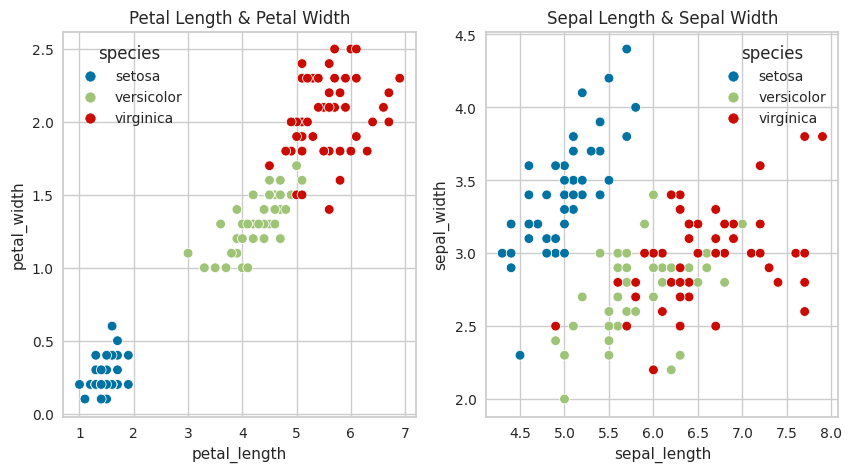

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

sb.scatterplot(data=iris, x='petal_length', y='petal_width', hue='species', ax=ax[0])
ax[0].set_title('Petal Length & Petal Width')

sb.scatterplot(data=iris, x='sepal_length', y='sepal_width', hue='species', ax=ax[1])
ax[1].set_title('Sepal Length & Sepal Width')

We could see that it's actually **much easier** if we **cluster** iris_data **using "petal_length" and "petal_width".** 

> But, **what if** we try to cluster using **"sepal_length" and "sepal_width"**? Can the algorithm cluster those iris_data similar to its species classification?

In [12]:
# mengambil fitur yang digunakan
X = iris_data[["sepal_length", "sepal_width"]]

# menentukan kolom target: "species"
y = iris_data.species

#### Opt 2: Feature Extraction

It is a method for reducing the dimensionality (ie. features) of data 

If we have m-columns, we can **reduce** it to m or fewer **columns**, <u>**whilst retaining the essence of the original data**</u> using *feature extraction* technique (eg. PCA, LDA)

**(-) of Feature Extraction**: lack of interpretability as features are not easily recognized anymore

In this tutorial, we're going to use PCA (Principal Component Analysis)

<details>
<summary>Benefits of PCA</summary>
Other benefits of PCA include <u>reduction of noise</u> in the data, feature selection (to a certain extent), and the ability to produce <u>independent, uncorrelated features</u> of the data. PCA also allows us to visualize data and allow for the inspection of clustering/classification algorithms. 
</details>

<details>
<summary>Limitation of PCA</summary>
only suitable for continuous, non-discrete data and sensitive to outliers
</details>

[datacamp: Tutorial PCA in Python](https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python)

[towardsdatascience: PCA using Python sklearn](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60)

In [13]:
# Create a PCA instance: pca
pca = PCA(n_components = 2)
pca_component = pca.fit_transform(iris_data) # fit on data to get Principal Components

pca_n_components = pca.n_components_ # getting value of PCA "n_components"
pca_variance = pca.explained_variance_ratio_ # getting explained variance ratio in each Principal Component

# Plot the explained variances
pca_result = pd.DataFrame({'PCA Feature': range(pca_n_components),
                           'Variance (%)': pca_variance})

fig = px.bar(pca_result, x= pca_result.columns[0], y= pca_result.columns[1], text= pca_result.columns[1])
fig.update_layout(title_text= 'Variation per Principal Component')
fig.show()

PCA 1 merepresentasikan 92% dari informasi keseluruhan, sementara PCA 2 merepresentasikan 4% informasi keseluruhan

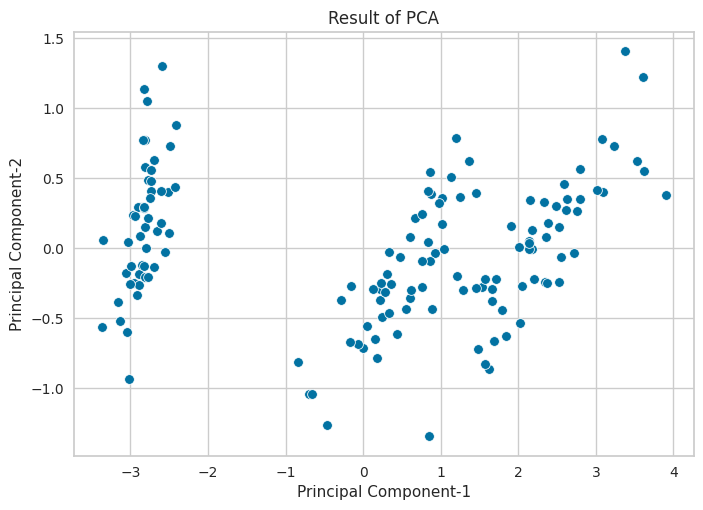

In [14]:
# create dataframe consist of principal component
df_pca = pd.DataFrame(data = pca_component, columns = ['Principal Component-1', 'Principal Component-2'])

# Data Visualization after PCA
sb.scatterplot(data= df_pca, x= df_pca.columns[0], y= df_pca.columns[1])
plt.title('Result of PCA')
plt.show()

In [15]:
X_pca = pca_component
X_pca[:5]

array([[-2.86541481,  0.29629459],
       [-2.89204667, -0.18378509],
       [-3.05498018, -0.17482656],
       [-2.92022951, -0.33158179],
       [-2.90685193,  0.29591692]])

### K-Means

Algoritma K-means menggunakan KMeans() pada library sklearn.cluster. 

*   n_clusters : total klaster yang digunakan; default = 8

[sklearn docs: KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)



In [16]:
n_cluster = 3
kmean = KMeans(n_clusters= n_cluster, n_init=10)

# fitting model
kmean.fit(X)

# ambil koordinat centroid
centroids = kmean.cluster_centers_
print("Koordinat Centroid\n{}".format(centroids))

# mengambil label hasil klaster
result_kmeans = X.copy()
result_kmeans['Cluster'] = kmean.labels_
result_kmeans

Koordinat Centroid
[[6.81276596 3.07446809]
 [5.006      3.428     ]
 [5.77358491 2.69245283]]


,sepal_length,sepal_width,Cluster
0,5.1,3.5,1
1,4.9,3.0,1
2,4.7,3.2,1
3,4.6,3.1,1
4,5.0,3.6,1
...,...,...,...
145,6.7,3.0,0
146,6.3,2.5,2
147,6.5,3.0,0
148,6.2,3.4,0


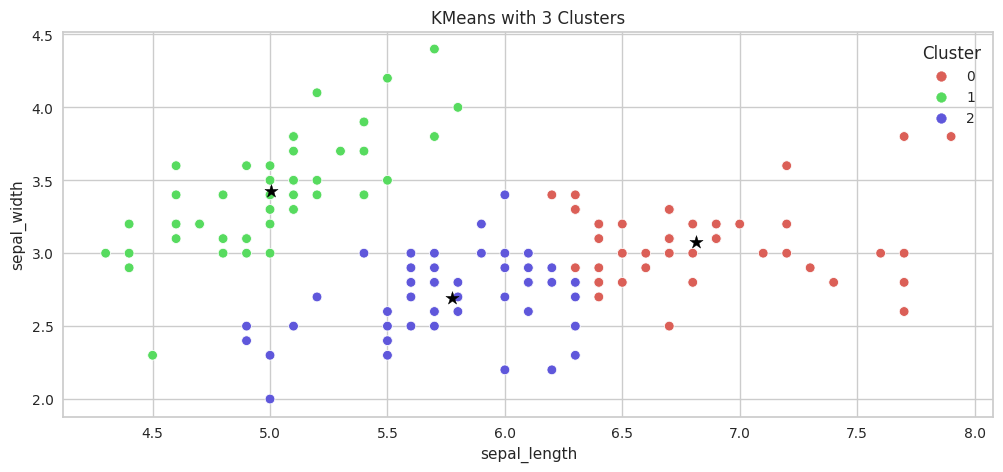

In [17]:
# plot clustering result
plt.figure(figsize=(12, 5))
sb.scatterplot(
    data= result_kmeans,
    x = 'sepal_length', y = 'sepal_width',
    hue = 'Cluster', 
    palette = sb.color_palette('hls', len(result_kmeans['Cluster'].unique())))

# plot the centroids
plt.scatter(x= centroids[:, 0], y= centroids[:, 1], 
            marker = "*", s = 100, color = 'black')

# define plot title
plt.title('KMeans with ' + str(n_cluster) + ' Clusters')
plt.show()

Text(0.5, 0.98, 'K-means')

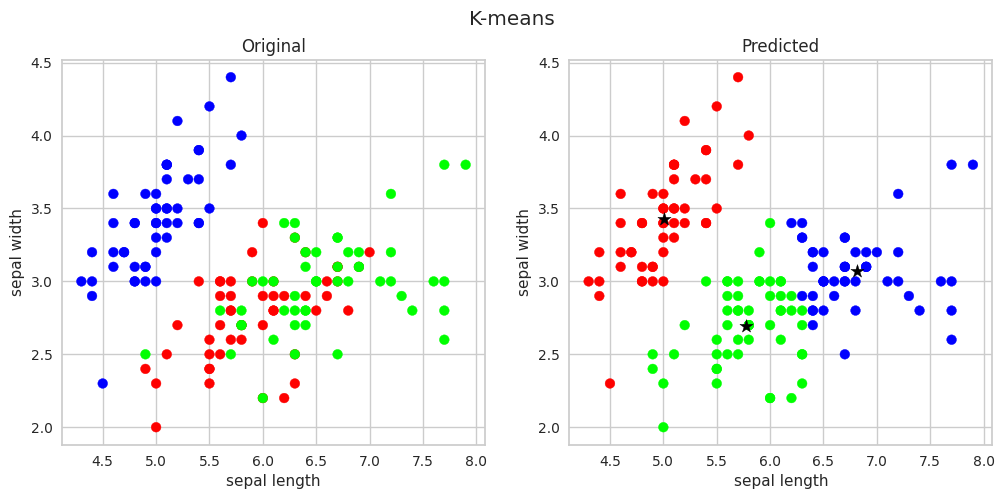

In [18]:
# visualisasi hasil klaster dengan kelas original
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].scatter(x= X['sepal_length'], y= X['sepal_width'], c= y, cmap='brg')
axes[0].set_title('Original')

axes[1].scatter(x= X['sepal_length'], y= X['sepal_width'], c= kmean.labels_, cmap='brg')
axes[1].scatter(x= centroids[:, 0], y= centroids[:, 1], c='black', marker='*', s=100)
axes[1].set_title('Predicted')

for i in range(2):
  axes[i].set_xlabel('sepal length')
  axes[i].set_ylabel('sepal width')

plt.suptitle('K-means')

You can cluster on all of the features but the consequences is how to visualize the result

In [19]:
X_all_features = iris.drop(columns = "species")

# pengaturan kmeans
kmean = KMeans(n_clusters=3, n_init=10)

# fitting model
kmean.fit(X_all_features)

# ambil koordinat centroid
centroids = kmean.cluster_centers_
print('Centroids:\n', centroids)

# mengambil label hasil klaster
X_all_features['Cluster'] = kmean.labels_
X_all_features

Centroids:
 [[5.9016129  2.7483871  4.39354839 1.43387097]
 [5.006      3.428      1.462      0.246     ]
 [6.85       3.07368421 5.74210526 2.07105263]]


,sepal_length,sepal_width,petal_length,petal_width,Cluster
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,0
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


#### How to find the best number of cluster in k-means?

> 1. Elbow curve

It works by finding WCSS (Within-Cluster Sum of Square) i.e. the sum of squared distance between points in a cluster and the cluster centroid. *Library used: yellowbrick.cluster.KElbowVisualizer

> 2. Silhouette score

The silhouette coefficient or silhouette score kmeans is a measure of how similar a data point is within-cluster (cohesion) compared to other clusters (separation). 

[towardsdatascience: elbow curve vs silhouette score](https://towardsdatascience.com/elbow-method-is-not-sufficient-to-find-best-k-in-k-means-clustering-fc820da0631d)

#### Plotting WCSS (known as **Elbow Curve**)

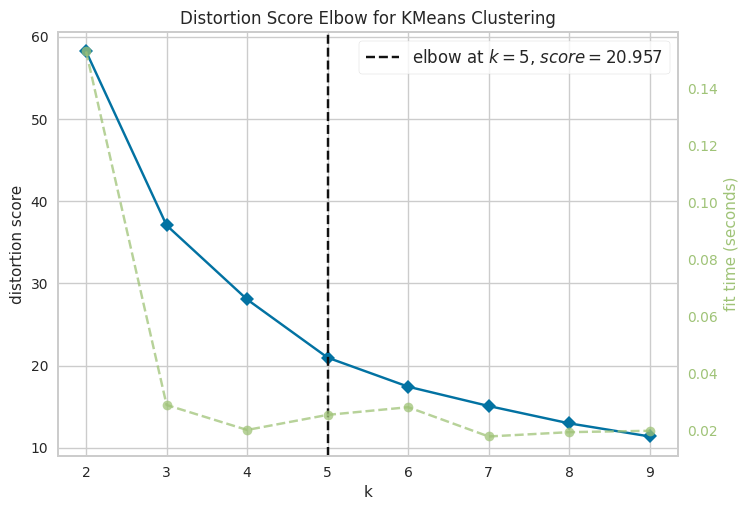

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
# Instantiate the clustering model and visualizer
kmean = KMeans(random_state=42, n_init=10)
visualizer = KElbowVisualizer(kmean, k=(2,10)) # visualiz WCSS between 2 - 10 clusters
 
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

#### Plotting Silhouette Score

The following **conditions** should be checked <u>**to pick the right ‘K’ using the Silhouette plots:**</u>

1. For a particular K, **all the clusters should have a Silhouette score more than the average score of the dataset** (represented by a *red dotted line*). The x-axis represents the Silhouette score. The clusters with K = 4 and 5 get eliminated as they don’t follow this condition.
2. **There should not be wide fluctuations in the size of the clusters**. The width of the clusters represents the number of data points. For K = 2, the blue cluster has almost twice the width as compared to the green cluster. This blue cluster gets broken down into 2 sub-clusters for K = 3 and thus forms clusters of uniform size.

So, the Silhouette plot approach gives us **K = 3 as the optimal value.**

Text(0.5, 0.98, 'K-means Silhouette score visualization')

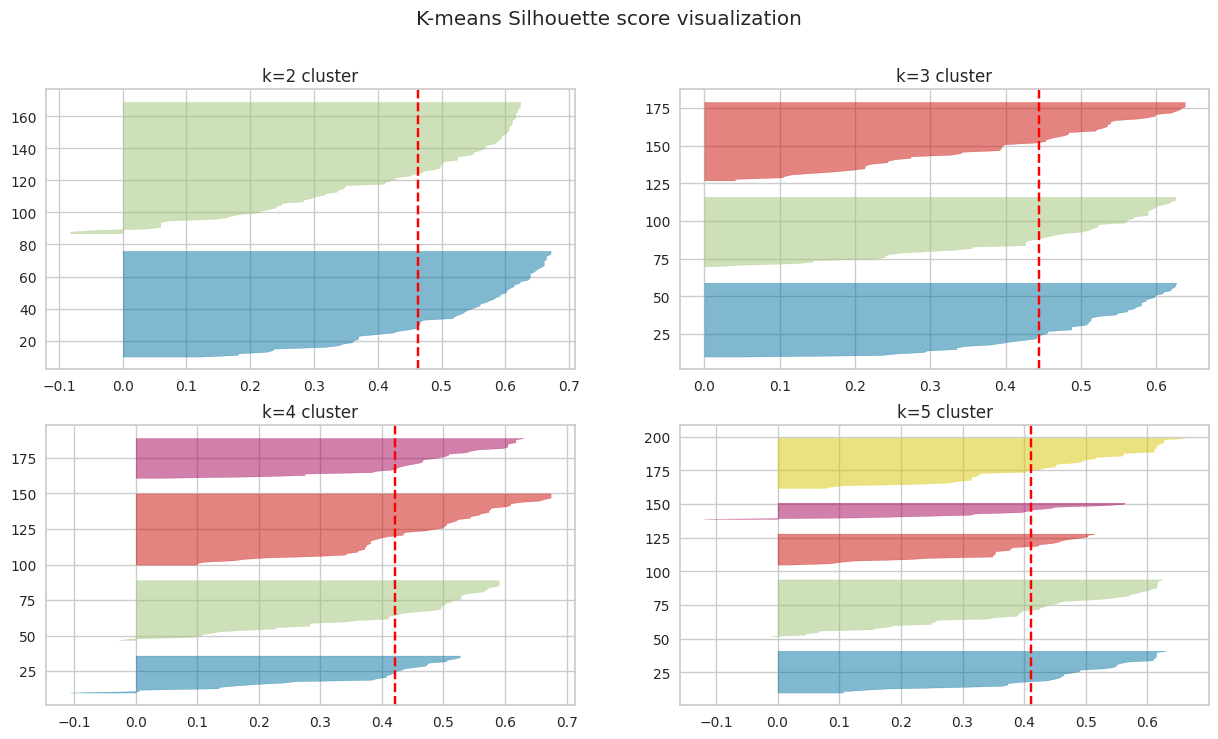

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for k in [2, 3, 4, 5]:
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters= k, n_init=10, max_iter=100, random_state=42)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    q, mod = divmod(k, 2) # subplots locator

    # silhouette visualizer
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod]) 
    ax[q-1][mod].set_title(f'k={k} cluster')
    visualizer.fit(X) 

plt.suptitle('K-means Silhouette score visualization')

#### Comparing clustering result of different "k" (num of clusters)

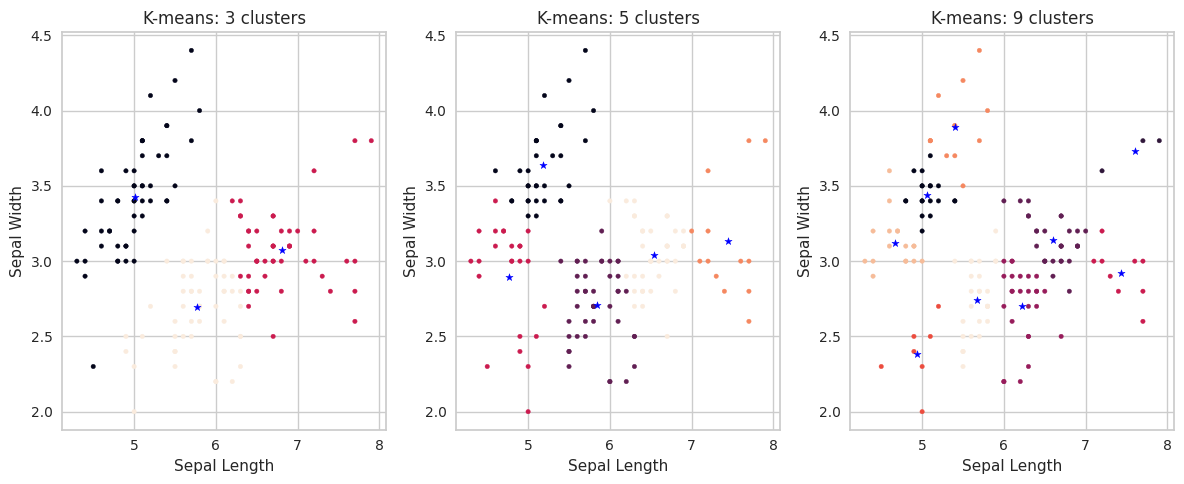

In [22]:
n_clusters_list = [3,5,9]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5))

for i, n_cluster in enumerate(n_clusters_list):
  kmeans = KMeans(n_clusters = n_cluster, random_state=42, n_init=10)
  kmeans.fit(X)
  centroids = kmeans.cluster_centers_

  ax[i].scatter(data= X, x="sepal_length", y="sepal_width", s=10, c = kmeans.labels_)
  ax[i].scatter(centroids[:, 0], centroids[:, 1], c="blue", marker='*', s=30)
  ax[i].set_xlabel('Sepal Length')
  ax[i].set_ylabel('Sepal Width')

  ax[i].set_title(f"K-means: {n_cluster} clusters")

plt.tight_layout()

### Bisecting K-Means

Bisecting k-means is a **hybrid approach** between **Divisive Hierarchical Clustering** (top down clustering) and **K-means Clustering**.

[bisecting k-means](https://medium.com/@afrizalfir/bisecting-kmeans-clustering-5bc17603b8a2)

<details>
<summary>Click to see Illustration of Bisecting K-means</summary>

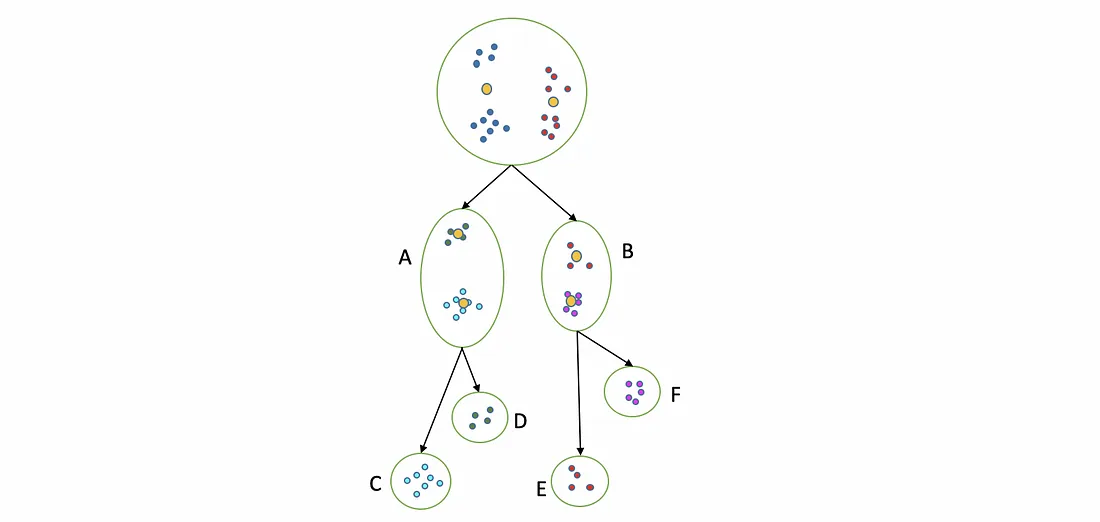

</details>

In [23]:
bisect = BisectingKMeans(n_clusters = 3, bisecting_strategy='biggest_inertia', random_state=42)
bisect.fit(X) # fit bisectingkmeans to data

bisect_labels = bisect.labels_ # cluster label result
bisect_center = bisect.cluster_centers_ # centroid of bisecting k-means

Text(0.5, 1.0, 'Bisecting K-means with 3 clusters')

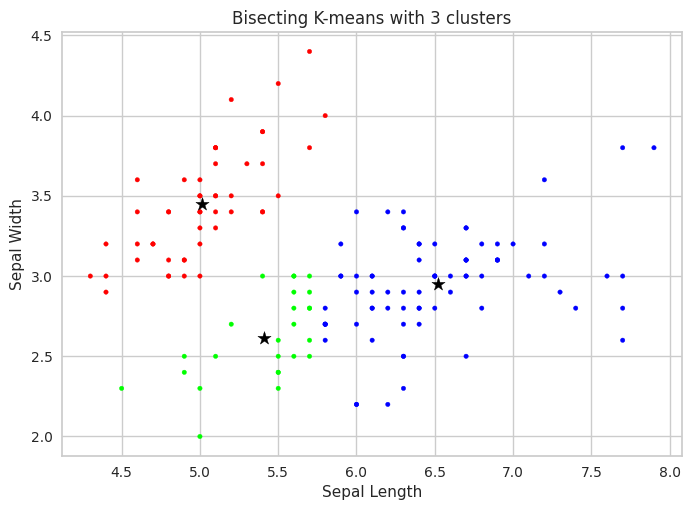

In [24]:
# visualize bisecting k-means

plt.scatter(data=X, x='sepal_length', y='sepal_width', c = bisect_labels, s=10, cmap='brg')
plt.scatter(bisect_center[:, 0], bisect_center[:, 1], marker='*', c='black', s=100)
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')

plt.title('Bisecting K-means with 3 clusters')

Text(0.5, 0.98, 'Bisecting K-means')

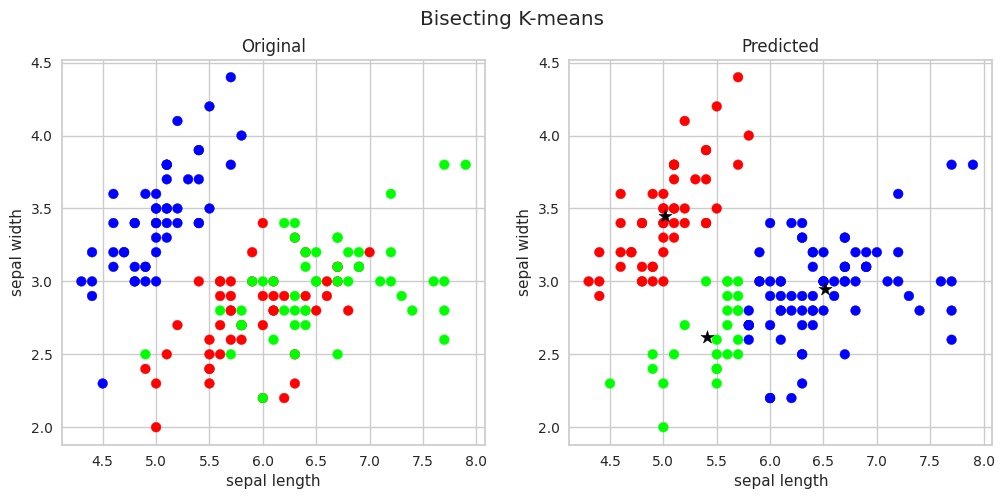

In [25]:
# visualisasi original vs bisecting k-means 3 clusters
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].scatter(x= X['sepal_length'], y= X['sepal_width'], c= y, cmap='brg')
axes[0].set_title('Original')

axes[1].scatter(x= X['sepal_length'], y= X['sepal_width'], c= bisect.labels_, cmap='brg')
axes[1].scatter(x= bisect_center[:, 0], y= bisect_center[:, 1], c='black', marker='*', s=100)
axes[1].set_title('Predicted')

for i in range(2):
  axes[i].set_xlabel('sepal length')
  axes[i].set_ylabel('sepal width')

plt.suptitle('Bisecting K-means')

#### K-means vs Bisecting K-means

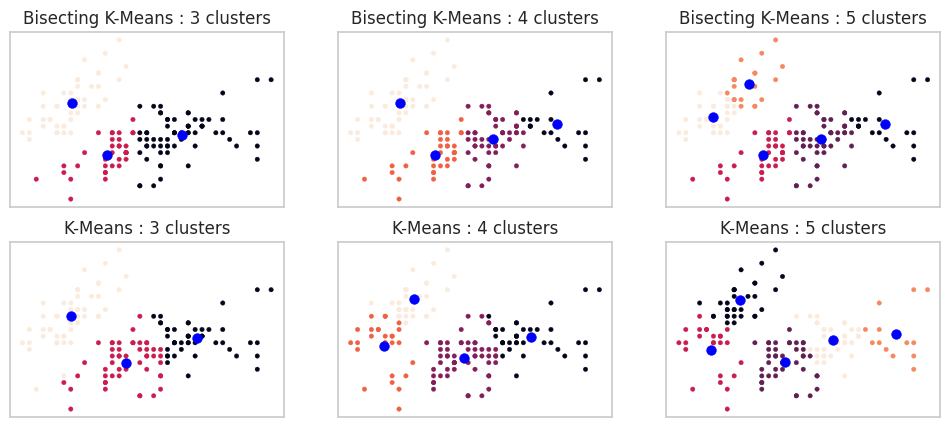

In [26]:
# Number of cluster centers for KMeans and BisectingKMeans
n_clusters_list = [3, 4, 5]

# Algorithms to compare
clustering_algorithms = {
    "Bisecting K-Means": BisectingKMeans,
    "K-Means": KMeans,
}

# Make subplots for each variant
fig, axs = plt.subplots(
    len(clustering_algorithms), len(n_clusters_list), figsize=(12, 5)
)

axs = axs.T

for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
    for j, n_clusters in enumerate(n_clusters_list):
        algo = Algorithm(n_clusters=n_clusters, n_init=3, random_state=42)
        algo.fit(X)
        centers = algo.cluster_centers_

        axs[j, i].scatter(data=X, x='sepal_length', y='sepal_width', s=10, c=algo.labels_)
        axs[j, i].scatter(centers[:, 0], centers[:, 1], c="blue", s=50)

        axs[j, i].set_title(f"{algorithm_name} : {n_clusters} clusters")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

### Vector Quantization


Library yang digunakan adalah library **scipy.cluster.vq**. 

[scipy docs: VQ](http://library.isr.ist.utl.pt/docs/scipy/cluster.vq.html)

> VQ & K-means


The result of k-means, a set of *centroids, can be used to quantize vectors*. **Quantization** aims to **find an encoding of vectors** that **reduces the expected distortion / distance.** VQ was initially used for ***data compression***.

<details>
<summary>What is distortion?</summary>
Distortion: Sum of the distances between each observation vector and its dominating centroid
</details>

<details>
<summary>Sources</summary>

[scipy explanation: VQ and K-means](https://docs.scipy.org/doc/scipy-0.8.x/reference/cluster.vq.html)

[analyticsvidhya: VQ & K-means for image compression](https://medium.com/analytics-vidhya/vector-quantization-using-k-means-algorithm-6382f3888326)
</details>




In [27]:
# Import Library
from scipy.cluster.vq import vq, kmeans
from pylab import plot, show

# mendapatkan centroid dengan k-means
codebook_vq, _ = kmeans(X, 3)

#mendapatkan hasil cluster VQ berdasarkan "initial centroid" dari k-means
cluster_vq,_ = vq(X, codebook_vq)

result_vq = X.copy()
result_vq['Cluster'] = cluster_vq
result_vq

,sepal_length,sepal_width,Cluster
0,5.1,3.5,1
1,4.9,3.0,1
2,4.7,3.2,1
3,4.6,3.1,1
4,5.0,3.6,1
...,...,...,...
145,6.7,3.0,0
146,6.3,2.5,2
147,6.5,3.0,0
148,6.2,3.4,0


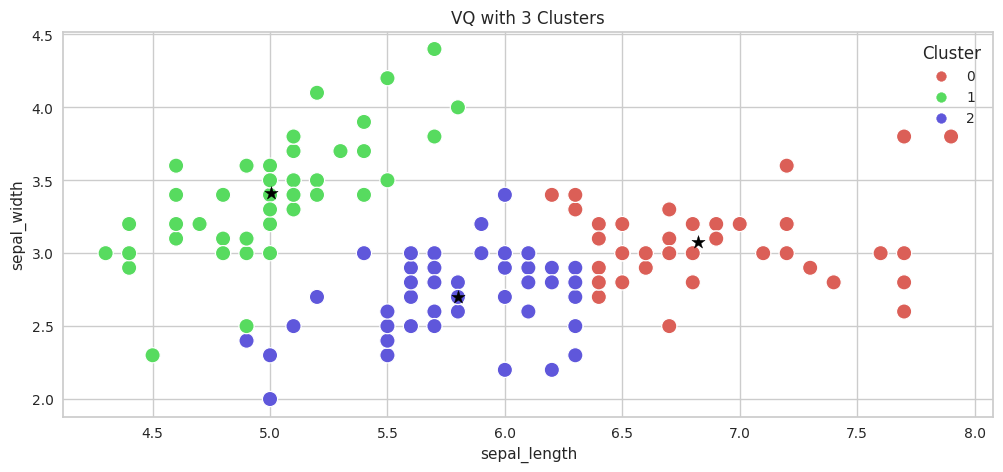

In [28]:
# plot clustering result
plt.figure(figsize=(12, 5))
sb.scatterplot(
    x=result_vq.iloc[:,0], y=result_vq.iloc[:,1],
    s = 120,
    hue= result_vq['Cluster'], 
    palette= sb.color_palette('hls', len(result_vq['Cluster'].unique())))

# plot the centroids
plt.scatter(codebook_vq[:, 0], codebook_vq[:, 1], marker = "*", s = 100, color = 'black')

# define plot title
plt.title('VQ with ' + str(len(result_vq.Cluster.unique())) + ' Clusters')
plt.show()

Text(0.5, 0.98, 'Vector Quantization')

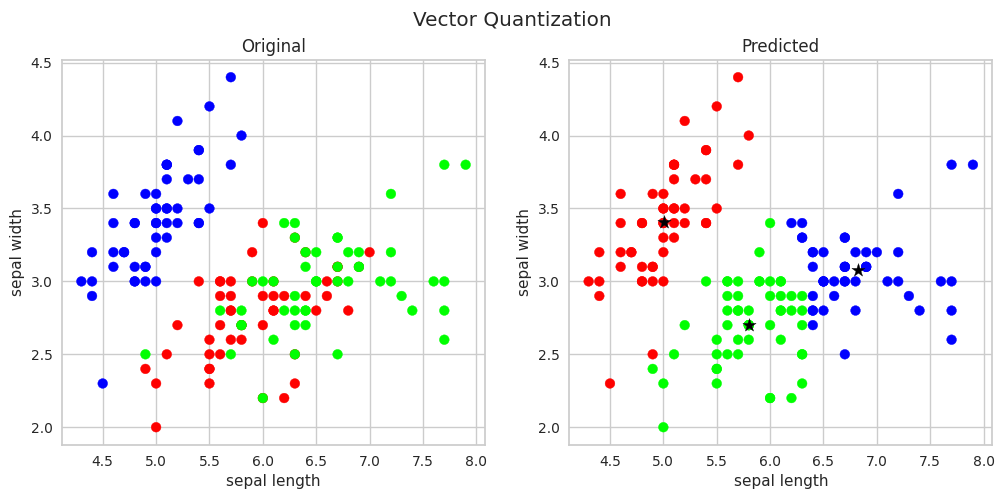

In [29]:
# visualisasi hasil klaster dengan kelas original
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].scatter(X[X.columns[0]], X[X.columns[1]], c= y, cmap='brg')
axes[0].set_title('Original')

axes[1].scatter(X[X.columns[0]], X[X.columns[1]], c= cluster_vq, cmap='brg')
axes[1].scatter(codebook_vq[:, 0], codebook_vq[:, 1], c='black', marker='*', edgecolor='k', s=100)
axes[1].set_title('Predicted')

for i in range(2):
  axes[i].set_xlabel('sepal length')
  axes[i].set_ylabel('sepal width')

plt.suptitle('Vector Quantization')

### Agglomerative Hierarchical Clustering


Agglomerative Hierarchical Clustering bisa diimplementasikan dengan library **scikit-learn** atau **scipy**.


#### via **Scikit-learn**




*   n_clusters : total klaster yang digunakan; default = 2
*   linkage : metode untuk menghitung jarak
    * "ward" (variance) --> **default**
    * "complete" (MAX distance)
    * "average" distance 
    * "single" (MIN distance)

[sklearn docs: agglom. clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
)

In [30]:
# membuat model
n_cluster= 3
agglo_model = AgglomerativeClustering(n_clusters= n_cluster, linkage="ward")
agglo_model.fit(X)

# mendapatkan cluster label
result_agglo = X.copy()
result_agglo['Cluster'] = agglo_model.labels_
result_agglo

,sepal_length,sepal_width,Cluster
0,5.1,3.5,1
1,4.9,3.0,1
2,4.7,3.2,1
3,4.6,3.1,1
4,5.0,3.6,1
...,...,...,...
145,6.7,3.0,0
146,6.3,2.5,2
147,6.5,3.0,0
148,6.2,3.4,0


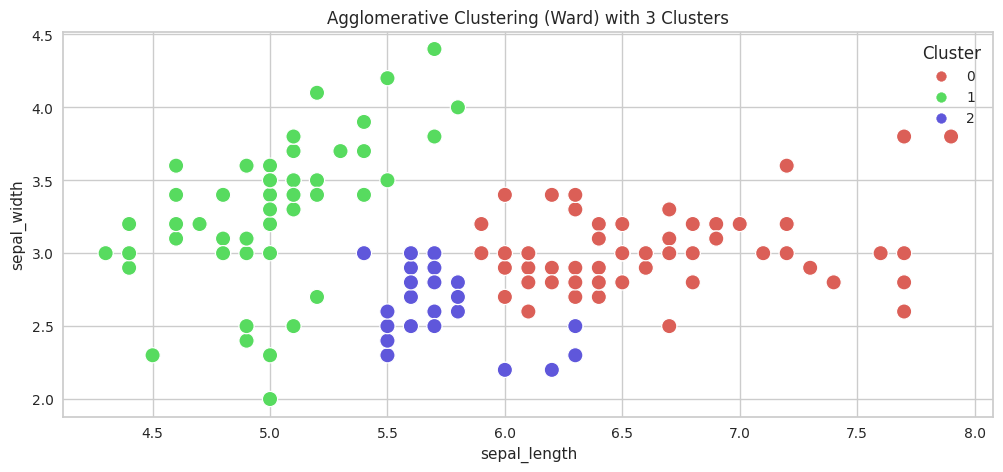

In [31]:
# plot clustering result
plt.figure(figsize=(12, 5))

sb.scatterplot(
    x= result_agglo.iloc[:,0], y= result_agglo.iloc[:,1],
    s = 120,
    hue= result_agglo['Cluster'], 
    palette= sb.color_palette('hls', n_cluster))

# define plot title
plt.title('Agglomerative Clustering (Ward) with ' + str(n_cluster) + ' Clusters')
plt.show()

Text(0.5, 0.98, 'Agglomerative Clustering (Ward)')

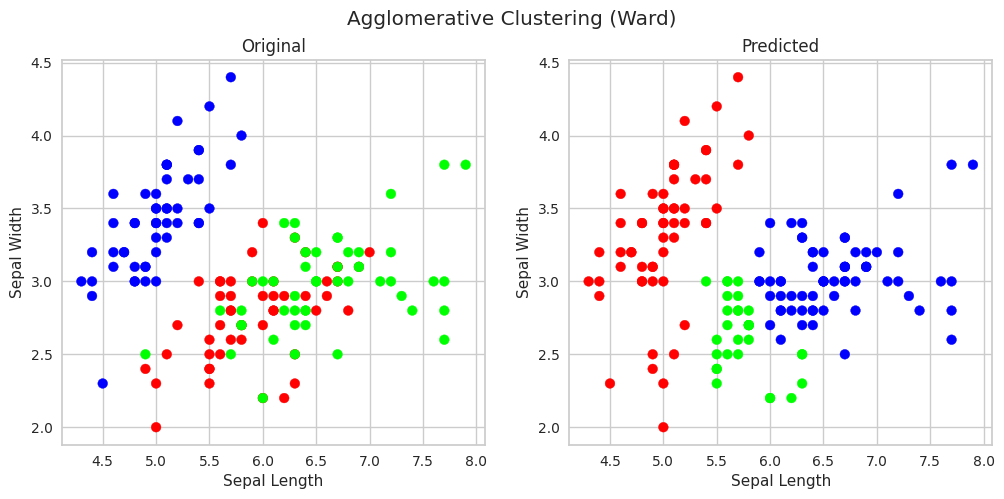

In [32]:
# visualisasi perbandingan kelas origin dengan hasil klaster
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

axes[0].scatter(X[X.columns[0]], X[X.columns[1]], c=y, cmap='brg')
axes[0].set_title('Original')

axes[1].scatter(X[X.columns[0]], X[X.columns[1]], c=agglo_model.labels_, cmap='brg')
axes[1].set_title('Predicted')

for i in range(2):
  axes[i].set_xlabel('Sepal Length')
  axes[i].set_ylabel('Sepal Width')

plt.suptitle('Agglomerative Clustering (Ward)')

Linkage method comparison in Agglomerative Hierarchical clustering:

 **Ward vs Single vs Complete vs Average**

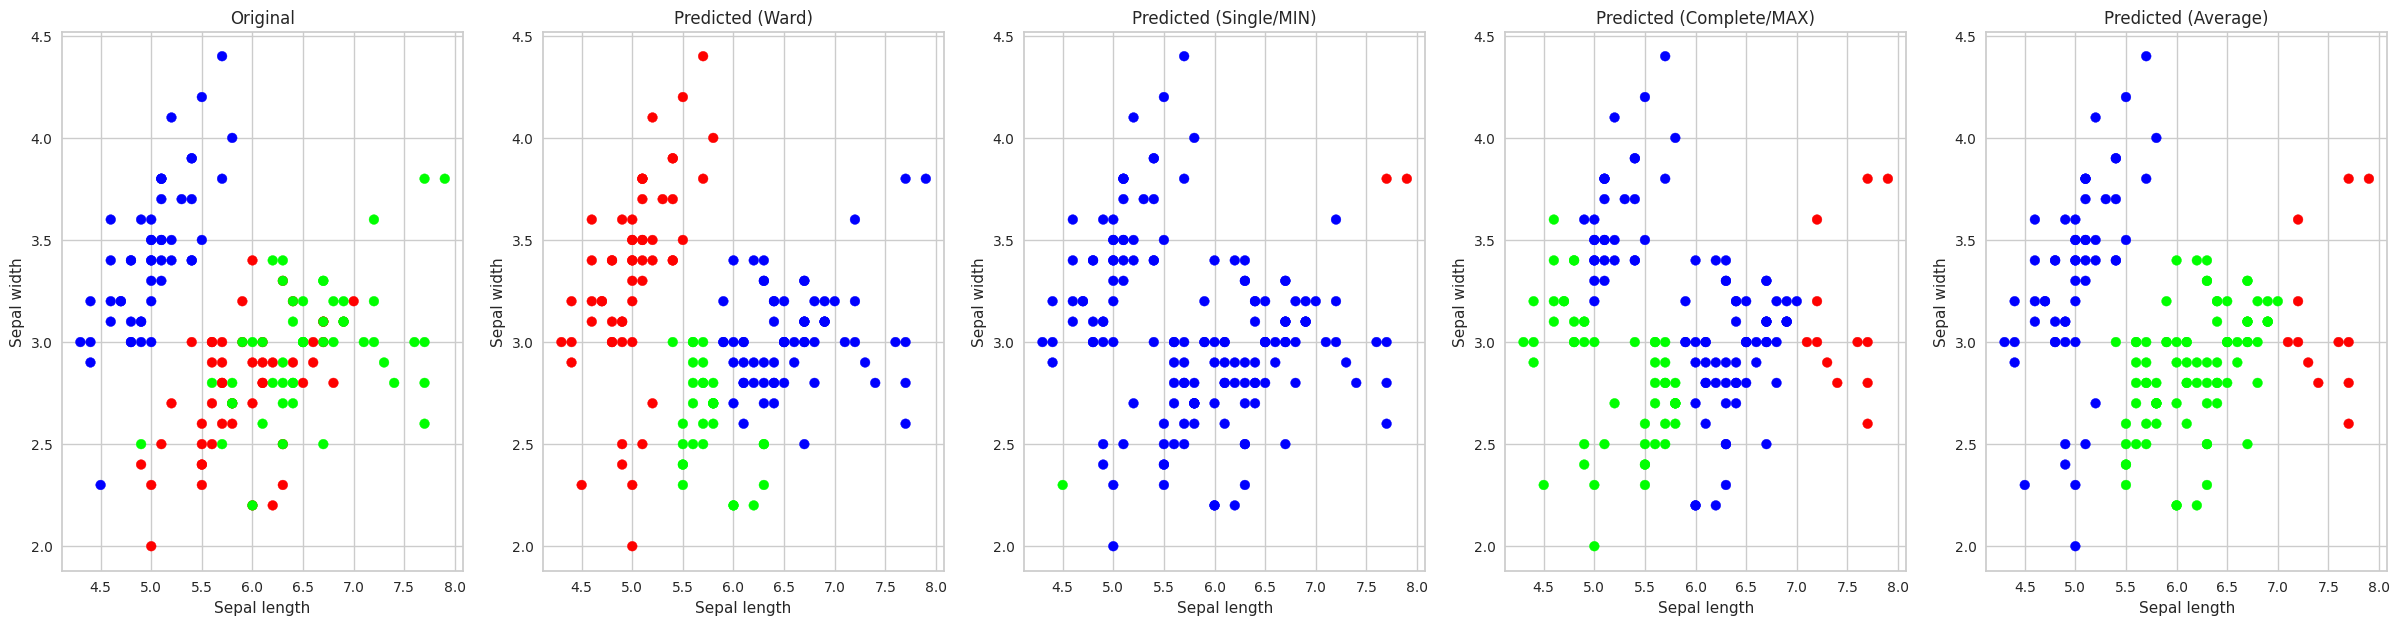

In [33]:
# agglomerative Ward
ward = AgglomerativeClustering(n_clusters=3, linkage="ward")
ward.fit(X)

# agglomerative single (MIN)
min = AgglomerativeClustering(n_clusters=3, linkage="single")
min.fit(X)

# agglomerative complete (MAX)
max = AgglomerativeClustering(n_clusters=3, linkage="complete")
max.fit(X)

# agglomerative average
avg = AgglomerativeClustering(n_clusters=3, linkage="average")
avg.fit(X)

ward_label = ward.labels_
min_label = min.labels_
max_label = max.labels_
avg_label = avg.labels_

# visualisasi perbandingan kelas origin dengan hasil klaster
fig, axes = plt.subplots(1, 5, figsize=(30,7))

axes[0].scatter(X[X.columns[0]], X[X.columns[1]], c=y, cmap='brg')
axes[0].set_xlabel('Sepal length')
axes[0].set_ylabel('Sepal width')
axes[0].set_title('Original')

for i, (agglom_cluster_label, agglom_method) in enumerate(zip([ward_label, min_label, max_label, avg_label],
                                                              ['Ward','Single/MIN','Complete/MAX','Average'])):
  axes[i+1].scatter(data=X, x='sepal_length', y='sepal_width', c=agglom_cluster_label, cmap='brg')
  axes[i+1].set_xlabel('Sepal length')
  axes[i+1].set_ylabel('Sepal width')
  axes[i+1].set_title('Predicted ({})'.format(agglom_method))

#### via **scipy**

* (+) Kelebihan: bisa dengan mudah memvisualisasikan dendrogram, lebih banyak variasi method-nya
* (-) Kekurangan: tidak bisa mengatur jumlah cluster

Caranya: 
1. Pertama, lakukan Agglomerative Hierarchical clustering dengan **scipy.cluster.hierarchy.linkage**. 
        Z = hierarchy.linkage(X, 'ward')

2. Lalu, dendrogram divisualisasikan melalui **scipy.cluster.hierarchy.dendrogram**
        dn = hierarchy.dendrogram(Z)

[scipy docs: agglom. hierarch.](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html)


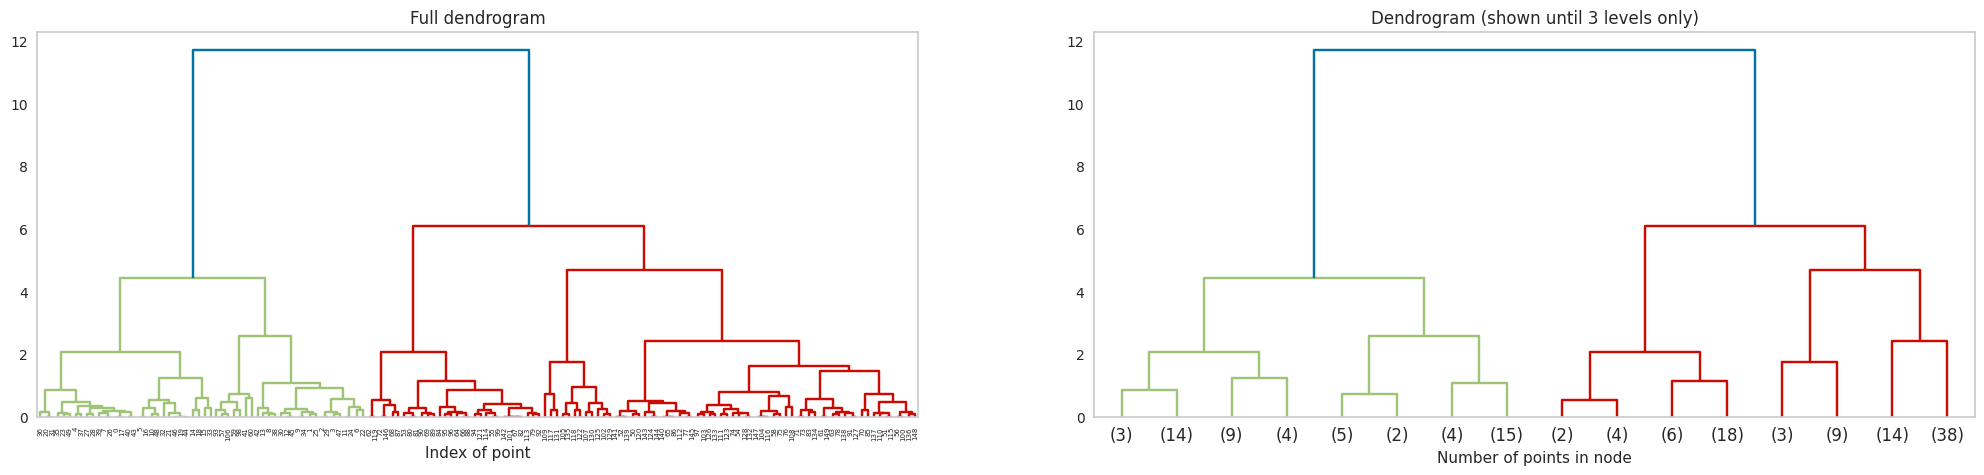

In [34]:
# create agglom. hierach. clustering
Z = hierarchy.linkage(X, 'ward') # method: 'ward', 'single' (MIN), 'average', 'complete' (MAX), 'weighted', 'centroid', 'median'



# visualize dendrogram
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 5))

dn_full = hierarchy.dendrogram(Z, 
                               ax=ax[0]) # full dendrogram, without specifying truncate_mode
ax[0].set_title('Full dendrogram')
ax[0].set_xlabel('Index of point')

dn_3level = hierarchy.dendrogram(Z, truncate_mode='level', p=3, # truncate dendrogram up to "p" levels
                                 ax=ax[1])
ax[1].set_title('Dendrogram (shown until 3 levels only)')
ax[1].set_xlabel('Number of points in node')

ax[0].grid(False)
ax[1].grid(False)

Dendrogram comparison of Agglomerative Hierarchical clustering methods:

 **Ward vs Single vs Complete vs Average**

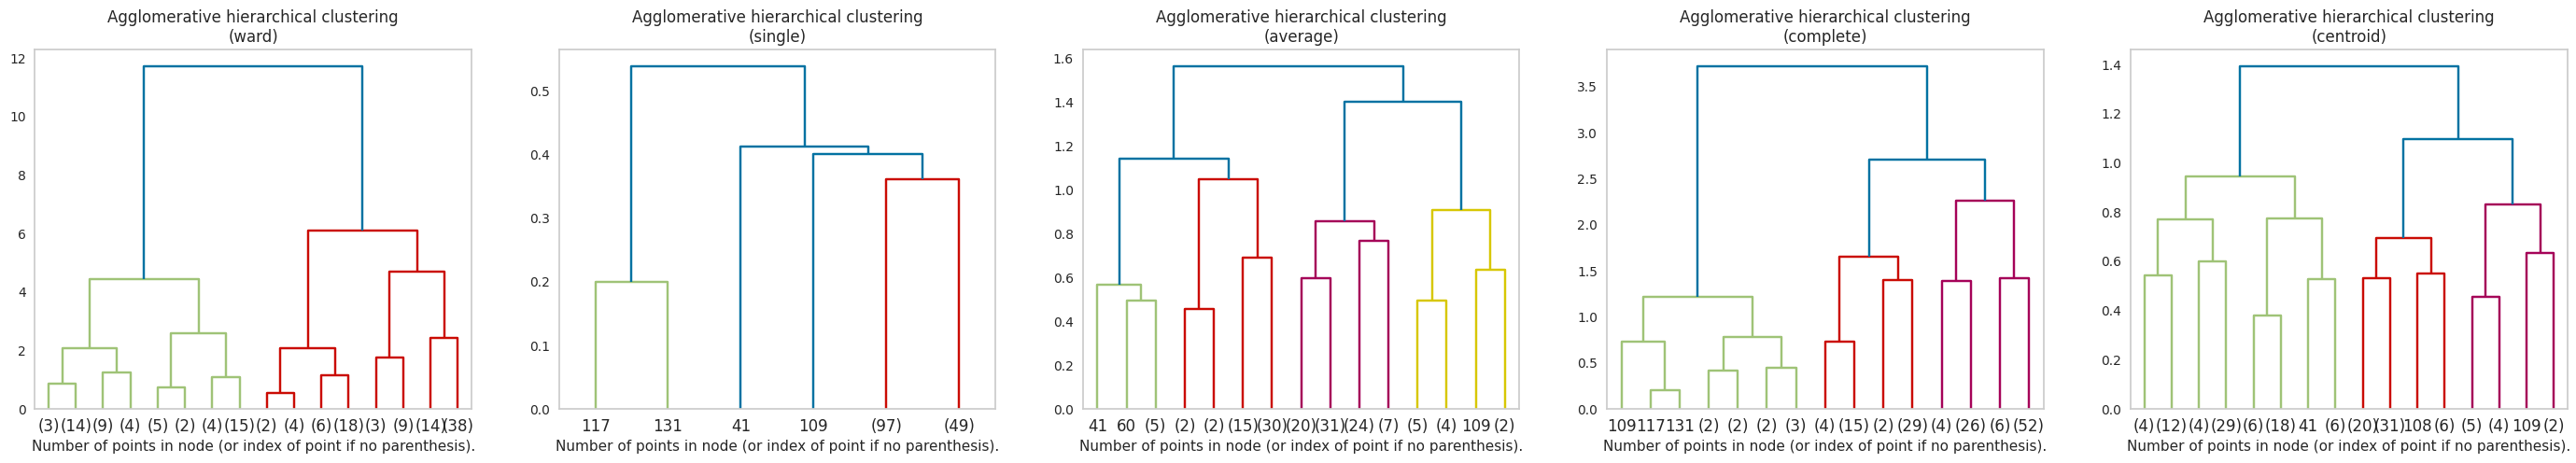

In [35]:
# generate agglomerative hierarchical clustering
Z_ward = hierarchy.linkage(X, 'ward')
Z_single = hierarchy.linkage(X, 'single')
Z_average = hierarchy.linkage(X, 'average')
Z_complete = hierarchy.linkage(X, 'complete')
Z_centroid = hierarchy.linkage(X, 'centroid')

# visualize dendrogram
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(35, 5))

for i, (Z_linkage, linkage_type) in enumerate(zip([Z_ward, Z_single, Z_average, Z_complete, Z_centroid],
                                                  ['ward','single','average','complete', 'centroid'])):
  dn = hierarchy.dendrogram(Z_linkage, truncate_mode='level', p=3, # truncate dendrogram up to "p" levels
                            ax=ax[i])
  ax[i].set_title(f'Agglomerative hierarchical clustering\n({linkage_type})')
  ax[i].set_xlabel('Number of points in node (or index of point if no parenthesis).')
  ax[i].grid(False)

### Divisive Hierarchical Clustering (Minimum Spanning Tree)


Minimum Spanning Tree menggunakan library mst_clustering (credits: @jakevdp on GitHub). 

*   min_cluster_size : jumlah minimum anggota dalam satu klaster; default = 1
*   cutoff : jumlah tepian yang dipotong

[jakevdp docs: mst_clustering](https://github.com/jakevdp/mst_clustering)

[MST tutorial](https://nbviewer.jupyter.org/github/jakevdp/mst_clustering/blob/master/MSTClustering.ipynb)




In [36]:
# mendefinisikan MST
mst_model = MSTClustering(min_cluster_size= 3, cutoff=5)

# membangun model cluster dan mengambil label hasil kluster
labels_minspantree = mst_model.fit_predict(X)

result_mst = X.copy()
result_mst['Cluster'] = labels_minspantree

In [37]:
def plot_mst(model, cmap='rainbow'):
    """Utility code to visualize a minimum spanning tree"""
    X = model.X_fit_
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
    for axi, full_graph, colors in zip(ax, [True, False], ['lightblue', model.labels_]):
        segments = model.get_graph_segments(full_graph=full_graph)
        axi.plot(segments[0], segments[1], '-k', zorder=1, lw=1)
        axi.scatter(X[:, 0], X[:, 1], c=colors, cmap=cmap, zorder=2)
        axi.axis('tight')
    
    ax[0].set_title('Full Minimum Spanning Tree', size=16)
    ax[1].set_title('Trimmed Minimum Spanning Tree', size=16);

<ipython-input-37-1857b893d840>:8: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



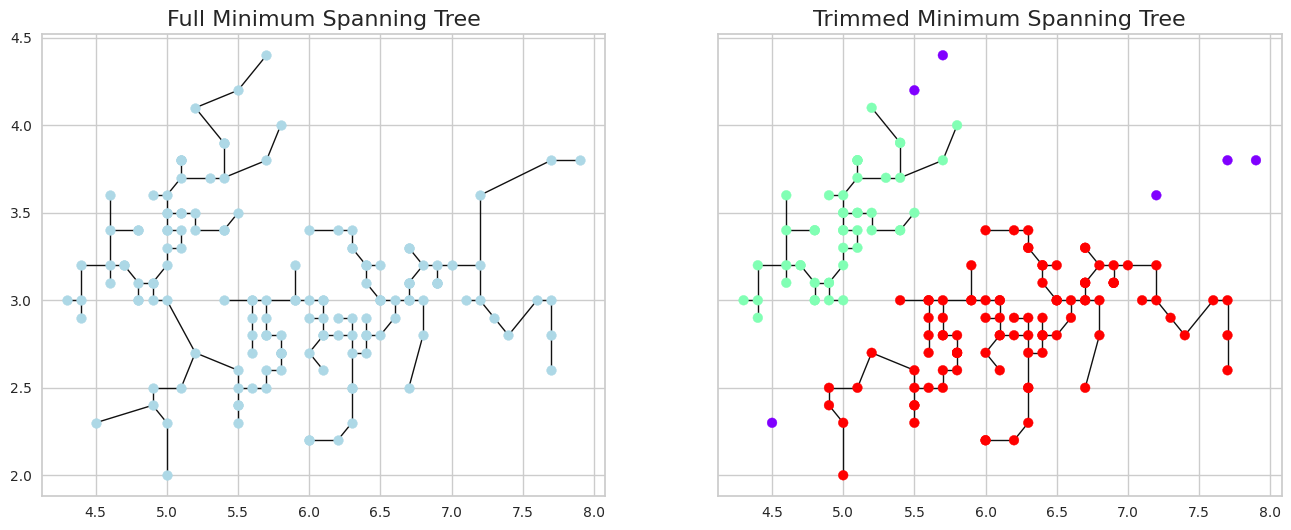

In [38]:
plot_mst(mst_model)

Text(0.5, 0.98, 'MST Clustering')

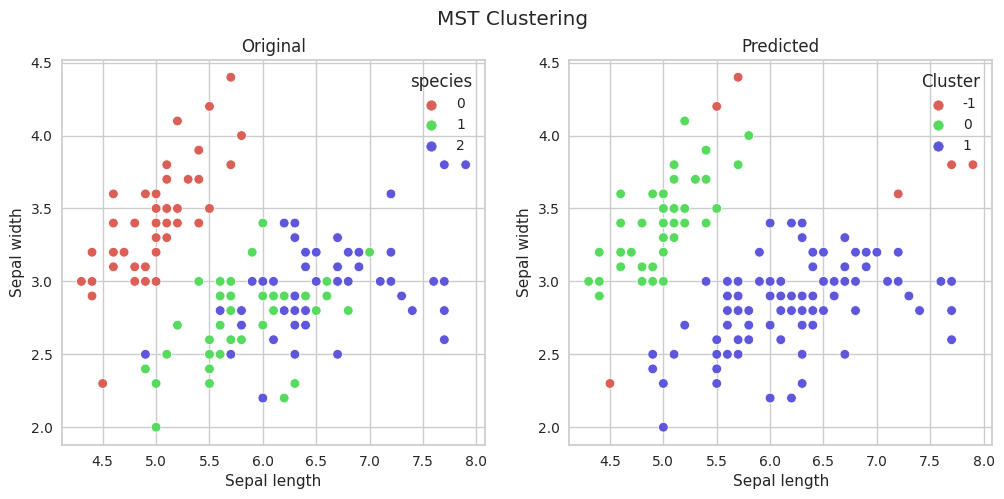

In [39]:
# visualisasi perbandingan kelas origin dengan hasil klaster
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sb.scatterplot(data= iris_data, x= 'sepal_length', y= 'sepal_width', hue= 'species', ax= axes[0], palette= sb.color_palette("hls", 3))
axes[0].set_title('Original')

sb.scatterplot(data= result_mst, x= 'sepal_length', y= 'sepal_width', hue= 'Cluster', ax= axes[1], palette= sb.color_palette("hls", 3))
axes[1].set_title('Predicted')

for i in range(2):
  axes[i].set_xlabel('Sepal length')
  axes[i].set_ylabel('Sepal width')

plt.suptitle('MST Clustering')

### DBSCAN



Density-based Clustering pada python bisa menggunakan library DBSCAN(). 

Parameter yang bisa digunakan dalam melakukan proses Clustering menggunakan DBSCAN adalah sebagai berikut:
*  eps : jarak maksimal antar dua data yang dianggap sebagai satu lingkup (neighborhood); default = 0.5
*  min_samples : total sampel dalam satu lingkup untuk sebuah poin disebut sebagai *core point*; default = 5

[sklearn docs: DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

> Side note: When using DBSCAN, ***outlier*** will be labelled as **(-1)**



In [40]:
# menggunakan DBSCAN
epsilon = 0.3
min_sample = 20
dbscan = DBSCAN(eps= epsilon, min_samples= min_sample)
dbscan.fit(X)

# mendapatkan label cluster
labels_dbscan = dbscan.labels_

result_dbscan = X.copy()
result_dbscan['Cluster'] = labels_dbscan

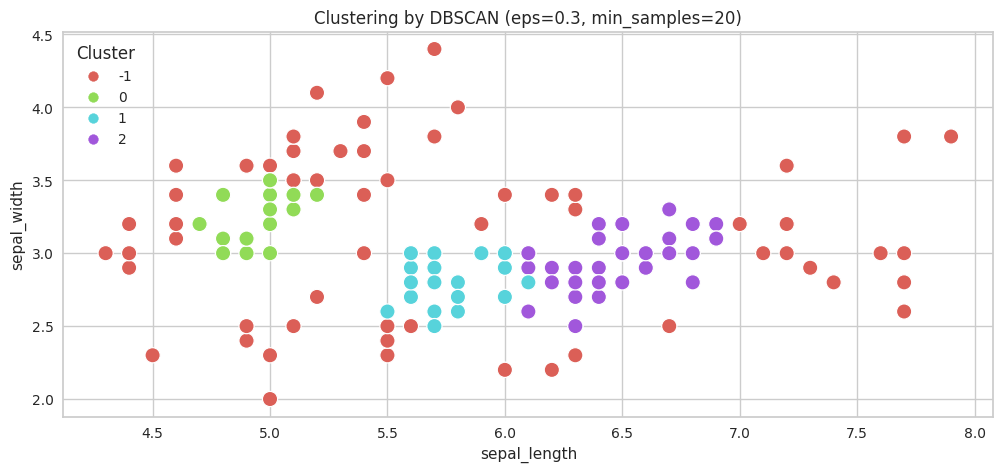

In [41]:
plt.figure(figsize=(12, 5))

sb.scatterplot(
    x= result_dbscan.iloc[:,0], y= result_dbscan.iloc[:,1], 
    hue= result_dbscan['Cluster'],
    s = 120,
    palette= sb.color_palette('hls', len(result_dbscan.Cluster.unique())))

plt.title('Clustering by DBSCAN (eps=0.3, min_samples=20)')
plt.show()

Text(0.5, 0.98, 'DBSCAN (eps=0.3, min_samples=20)')

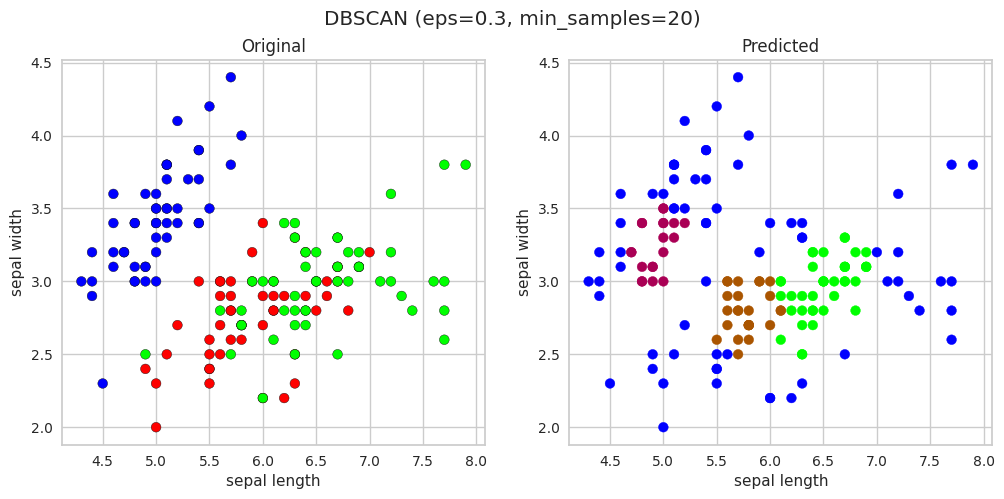

In [42]:
# Plot the identified clusters and compare
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].scatter(X[X.columns[0]], X[X.columns[1]], c=y, cmap='brg', edgecolor='k')
axes[0].set_title('Original')

axes[1].scatter(X[X.columns[0]], X[X.columns[1]], c=labels_dbscan, cmap='brg')
axes[1].set_title('Predicted')

for i in range(2):
  axes[i].set_xlabel('sepal length')
  axes[i].set_ylabel('sepal width')

plt.suptitle('DBSCAN (eps=0.3, min_samples=20)')

#### What if we change the epsilon of DBSCAN?

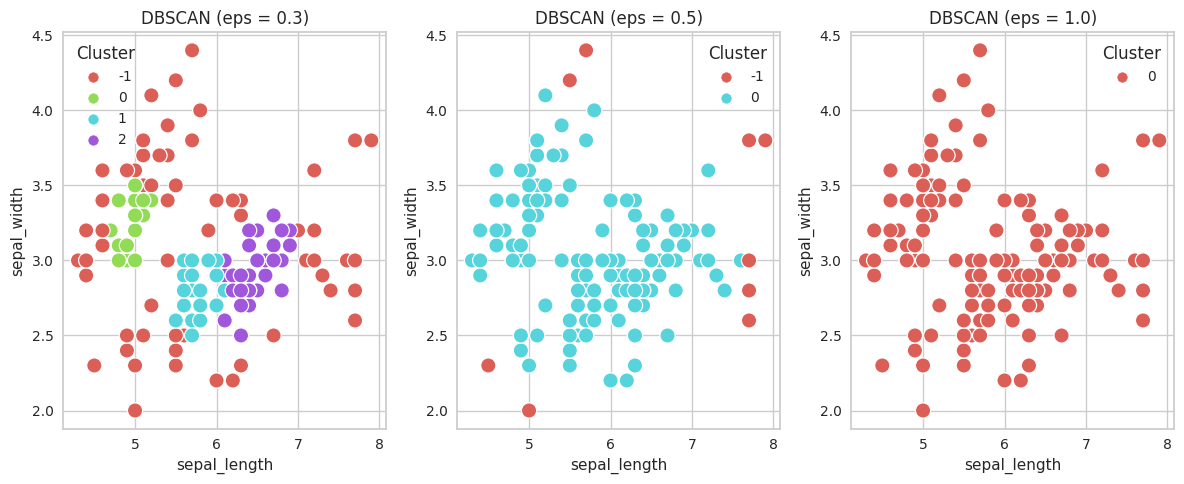

In [43]:
eps_list = [.3, .5, 1.]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5))

for i, eps in enumerate(eps_list):
  dbscan = DBSCAN(eps= eps, min_samples=20)
  dbscan.fit(X)
  result_dbscan = X.copy()
  result_dbscan['Cluster'] = dbscan.labels_

  sb.scatterplot(data=result_dbscan,
                 x='sepal_length',
                 y='sepal_width', 
                 hue= result_dbscan['Cluster'],
                 s = 120,
                 palette=sb.color_palette('hls', len(result_dbscan['Cluster'].unique())),
                 ax = ax[i])
  
  ax[i].set_title(f"DBSCAN (eps = {eps})")
  
plt.tight_layout()

#### What if we change min_samples?

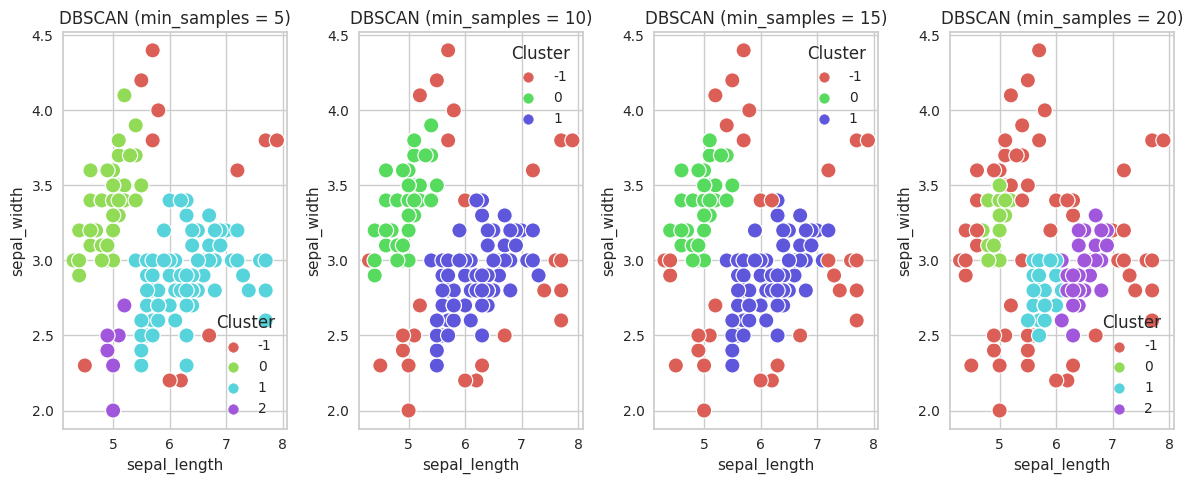

In [44]:
#@title
min_samples_list = [5, 10, 15, 20]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,5))

for i, min_samples in enumerate(min_samples_list):
  dbscan = DBSCAN(eps= .3, min_samples= min_samples)
  dbscan.fit(X)
  result_dbscan = X.copy()
  result_dbscan['Cluster'] = dbscan.labels_

  sb.scatterplot(data= result_dbscan,
                 x='sepal_length',
                 y='sepal_width', 
                 hue= result_dbscan['Cluster'],
                 s = 120,
                 palette=sb.color_palette('hls', len(result_dbscan['Cluster'].unique())),
                 ax = ax[i])
  
  ax[i].set_title(f"DBSCAN (min_samples = {min_samples})")
  
plt.tight_layout()

### **Cluster Validity**

Why?
* To avoid finding patterns in noise
* To compare clustering algorithms
* To compare two sets of cluster
* To compare two clusters

There are:
* **External measures** Used to measure the extent to which cluster labels match
externally supplied class ***labels*** (obtained, e.g., by human assessors)
* **Internal measures** Used to measure the goodness of a clustering structure
without respect to external information eg. WCSS, Silhouette

#### **External measures**

##### Correlation

Correlation akan melihat **seberapa baik korelasi antara grup hasil clustering dengan grup aslinya**. Semakin tinggi korelasi, artinya hasil klasterisasi sudah mendekati seperti klasifikasi aslinya, sehingga dapat dikatakan clustering tsb. berhasil.

***High*** *correlation indicates that **points that related to the same cluster** are <u>**close**</u> to each other*

Contoh: membandingkan correlation pada hasil clustering **K-means dengan Bisecting K-means**

**Original matrix**

In [45]:
# retrieve the original dataset which contains the independent feature that used for clustering analysis
original = pd.concat([X, y], axis=1)
original['species'] = original.species.astype('category')
original['species'] = original.species.cat.codes
original

,sepal_length,sepal_width,species
0,5.1,3.5,0
1,4.9,3.0,0
2,4.7,3.2,0
3,4.6,3.1,0
4,5.0,3.6,0
...,...,...,...
145,6.7,3.0,2
146,6.3,2.5,2
147,6.5,3.0,2
148,6.2,3.4,2


 **Example: Cluster matrix of K-means**

In [46]:
# K-means clustering
kmean = KMeans(n_clusters= 3, n_init=10, random_state=42)
kmean.fit(X)
kmean_labels = kmean.labels_

predicted_kmeans = X.copy()
predicted_kmeans["species_predicted"] = kmean_labels
predicted_kmeans

,sepal_length,sepal_width,species_predicted
0,5.1,3.5,0
1,4.9,3.0,0
2,4.7,3.2,0
3,4.6,3.1,0
4,5.0,3.6,0
...,...,...,...
145,6.7,3.0,1
146,6.3,2.5,2
147,6.5,3.0,1
148,6.2,3.4,1


In [47]:
# Mengubah label cluster, diperlukan JIKA ingin membandingkan nilai cluster karena urutan label cluster bisa jadi berbeda dengan urutan label aslinya
# for index, item in enumerate(kmean_labels):
#     if (item == 0):
#         kmean_labels[index] = 1
#     elif (item == 1):
#         kmean_labels[index] = 2
#     elif (item == 2):
#         kmean_labels[index] = 0
# kmean_labels

In [48]:
# membuat incidences matrix
incidences_kmean = []
for index, item in enumerate(y):
  if (kmean_labels[index] == y[index]) :
    incidences_kmean.append(1)
  else :
    incidences_kmean.append(0)
incidences_kmean

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1]

In [49]:
# Menghitung korelasi distance matrix dengan incidence matrix
kmean_cluster_correlation = corrcoef(distance_matrix(original, predicted_kmeans), incidences_kmean)[1,0]

print("Cluster Correlation of {0}: {1}".format(kmean.__class__.__name__, np.round(kmean_cluster_correlation, 3)))

Cluster Correlation of KMeans: 0.961


**Example: Cluster matrix of Bisecting K-means**

In [50]:
# Proses clustering dengan mengambil label baru hasil cluster
bisect = BisectingKMeans(n_clusters = 3, bisecting_strategy='biggest_inertia', random_state=42)
bisect.fit(X) 
bisect_labels = bisect.labels_

predicted_bisect = X.copy()
predicted_bisect['species_predicted'] = bisect_labels
predicted_bisect

,sepal_length,sepal_width,species_predicted
0,5.1,3.5,1
1,4.9,3.0,1
2,4.7,3.2,1
3,4.6,3.1,1
4,5.0,3.6,1
...,...,...,...
145,6.7,3.0,0
146,6.3,2.5,0
147,6.5,3.0,0
148,6.2,3.4,0


In [51]:
# Mengubah label cluster, diperlukan JIKA ingin membandingkan nilai cluster karena urutan label cluster bisa jadi berbeda dengan urutan label aslinya
for index, item in enumerate(bisect_labels):
    if (item == 1):
        bisect_labels[index] = 0
    elif (item == 0):
        bisect_labels[index] = 2
    elif (item == 2):
        bisect_labels[index] = 1
bisect_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2,
       1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2,
       1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [52]:
# membuat incidences matrix
incidences_bisect = []
for index, item in enumerate(y):
  if (bisect_labels[index] == y[index]) :
    incidences_bisect.append(1)
  else :
    incidences_bisect.append(0)
incidences_bisect

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [53]:
# Menghitung korelasi distance matrix dengan incidence matrix
bisect_cluster_correlation = corrcoef(distance_matrix(original, predicted_bisect), incidences_bisect)[1,0]

print("Cluster Correlation of {0}: {1}".format(dbscan.__class__.__name__, np.round(bisect_cluster_correlation, 3)))

Cluster Correlation of DBSCAN: 0.955


In [54]:
# store the model performance in a table
model_performance = pd.DataFrame({
    'Cluster Algorithm' : [kmean.__class__.__name__, bisect.__class__.__name__],
    'Correlation Score': [np.round(kmean_cluster_correlation,3), np.round(bisect_cluster_correlation,3)]
})
model_performance = model_performance.sort_values(model_performance.columns[1], ascending = False)

fig = px.bar(model_performance, x= model_performance.columns[0], y= model_performance.columns[1], text= model_performance.columns[1])
fig.update_layout(title_text= "aa")
fig.show()

##### Similarity Matrix

Mencari matriks kesamaan pada python salah satu cara yang bisa digunakan adalah dengan menggunakan *cosine similarity*. Dari nilai *cosine similarity* tersebut, kemudian dapat kita buat visualisasinya

In [55]:
pd.set_option('display.max_rows', 10)

In [56]:
# retrieve the original dataset which contains the independent feature that used for clustering analysis
original = pd.concat([X, y], axis=1)
original['species'] = original['species'].astype('category')
original['species'] = original['species'].cat.codes
original

,sepal_length,sepal_width,species
0,5.1,3.5,0
1,4.9,3.0,0
2,4.7,3.2,0
3,4.6,3.1,0
4,5.0,3.6,0
...,...,...,...
145,6.7,3.0,2
146,6.3,2.5,2
147,6.5,3.0,2
148,6.2,3.4,2


In [57]:
# Proses clustering dengan mengambil label baru hasil cluster
kmean = KMeans(n_clusters=3, n_init=10, random_state=42)
kmean.fit(X)
kmean_labels = kmean.labels_

predicted_kmean = X.copy()
predicted_kmean["species_predicted"] = kmean_labels
predicted_kmean

,sepal_length,sepal_width,species_predicted
0,5.1,3.5,0
1,4.9,3.0,0
2,4.7,3.2,0
3,4.6,3.1,0
4,5.0,3.6,0
...,...,...,...
145,6.7,3.0,1
146,6.3,2.5,2
147,6.5,3.0,1
148,6.2,3.4,1


In [58]:
# Menampilkan perbedaan dari kedua matriks. 
pd.set_option('display.max_rows', 150)

pd.concat([ original['species'], 
           predicted_kmean['species_predicted'] ], axis=1)

,species,species_predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [59]:
pd.set_option('display.max_rows', 10)

In [60]:
# Mengubah hasil cluster, diperlukan jika ingin membandingkan nilai cluster karena hasil cluster bisa jadi berbeda
predicted_kmean["species_predicted"].replace({2: 1, 
                                              1: 2}, inplace=True)

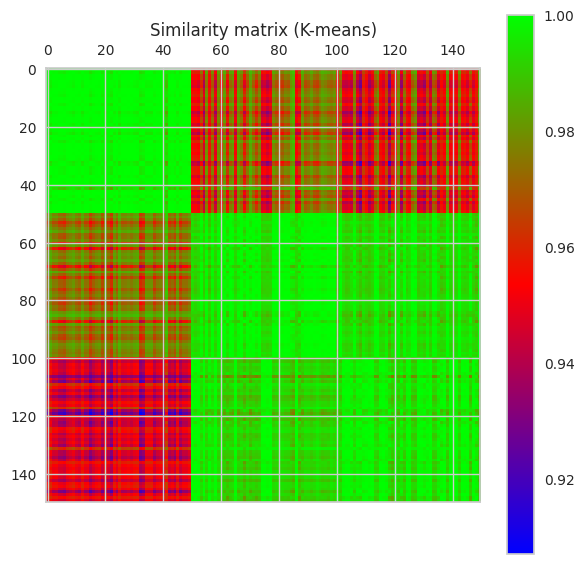

In [61]:
# Menampilkan cosine similarity
cosine_matrix = cosine_similarity(original, predicted_kmean)
# print(cosine_matrix)

fig, ax = plt.subplots(figsize=(7, 7))
cax = ax.matshow(cosine_matrix, interpolation='nearest', cmap='brg')
ax.grid(True)
plt.title('Similarity matrix (K-means)')

fig.colorbar(cax)
plt.show()

##### Purity

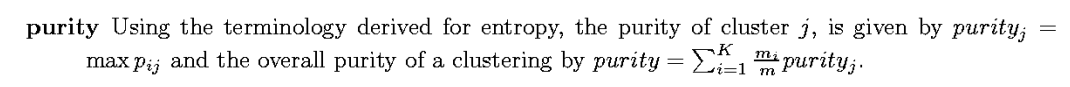

[how-to purity in Python](https://stackoverflow.com/questions/34047540/python-clustering-purity-metric)

[calculating purity](https://stats.stackexchange.com/questions/95731/how-to-calculate-purity)

In [62]:
from sklearn.metrics.cluster import contingency_matrix

def purity(y_true, y_pred):

    # compute contingency matrix (also called confusion matrix)
    contingency = contingency_matrix(y_true, y_pred)

    # return overall purity & purity per cluster
    purity_overall = np.sum(np.amax(contingency, axis=0)) / np.sum(contingency) 
    purity_per_cluster = np.amax(contingency, axis=1) / np.sum(contingency, axis=1)
    
    return purity_overall, purity_per_cluster

In [63]:
# K-means Contingency matrix
print('Contingency matrix of\nLabels vs K-means Prediction\n')
print(contingency_matrix(original['species'], predicted_kmean['species_predicted']))

# Purity of K-means
print('\n(K-means)')
purity_kmean = purity(original['species'], predicted_kmean['species_predicted'])
print('Overall purity:', purity_kmean[0])
print('Purity per cluster:', purity_kmean[1])

Contingency matrix of
Labels vs K-means Prediction

[[50  0  0]
 [ 0 38 12]
 [ 0 15 35]]

(K-means)
Overall purity: 0.82
Purity per cluster: [1.   0.76 0.7 ]


In [64]:
# Bisecting K-means Contingency matrix
print('Contingency matrix of\nLabels vs Bisecting K-means Prediction\n')
print(contingency_matrix(original['species'], predicted_bisect['species_predicted']))

# Purity of Bisecting K-means
print('\n(Bisecting K-means)')
purity_bisect = purity(original['species'], predicted_bisect['species_predicted'])
print('Overall purity:', purity_bisect[0])
print('Purity per cluster:', purity_bisect[1])

Contingency matrix of
Labels vs Bisecting K-means Prediction

[[ 0 49  1]
 [29  0 21]
 [47  0  3]]

(Bisecting K-means)
Overall purity: 0.78
Purity per cluster: [0.98 0.58 0.94]


#####  Entropy

[calculating entropy](https://stats.stackexchange.com/questions/338719/calculating-clusters-entropy-python)

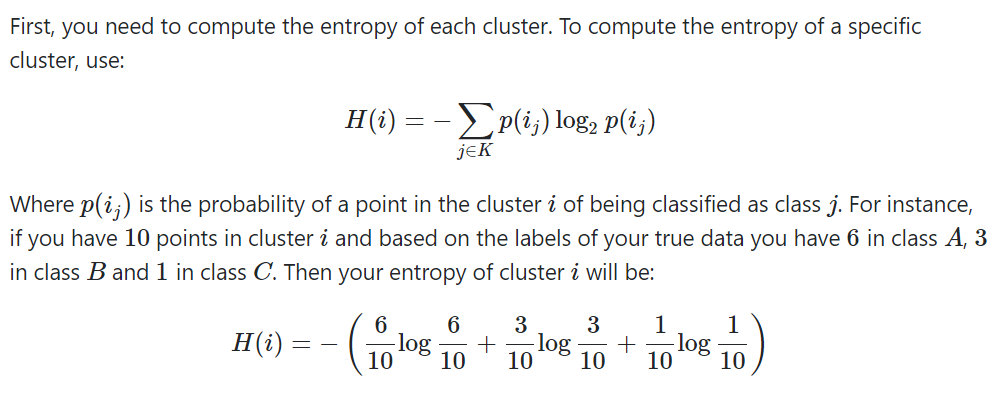

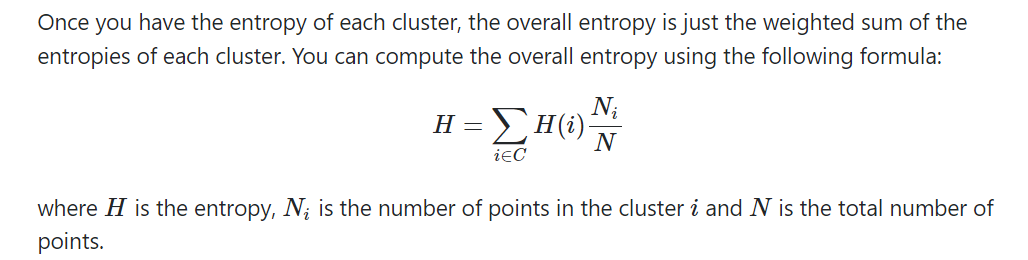

In [65]:
def clustering_entropy(y_true, y_pred):

  # concat y_true & y_pred into a table
  df = pd.concat([pd.DataFrame({'true':y_true}), pd.DataFrame({'predict':y_pred})], axis=1)
  
  # get total rows
  len_df = len(df)

  # get unique cluster label
  cluster_label_index = np.unique(y_pred) 

  # create empty list for storing (length per cluster) and (entropy per cluster)
  len_per_cluster = []
  entropy_per_cluster = []

  for cluster in cluster_label_index:
      df_cluster = df[ df['predict'] == cluster ] # filter df, select rows with specific cluster
      len_cluster = len(df_cluster); len_per_cluster.append(len_cluster) # get length of a cluster
      true_class_in_cluster = df_cluster['true'].value_counts().values # get the actual classes in that cluster

      # calculate pij (probability of a point in the cluster i of being classified as class j)
      class_prob = true_class_in_cluster / len_cluster 

      # finally, calculate entropy of that cluster
      entropy_cluster = entropy(class_prob, base=2); entropy_per_cluster.append(entropy_cluster)

  # weighted sum of all clusters; entropy
  entropy_overall = np.sum([entrop_clust * len_clust / len_df 
                            for entrop_clust, len_clust in zip(entropy_per_cluster, len_per_cluster)])

  return entropy_overall, entropy_per_cluster

In [66]:
# Entropy of K-means
print('(K-means)')
entropy_kmean = clustering_entropy(original['species'], predicted_kmean['species_predicted'])
print('Overall entropy:', entropy_kmean[0])
print('Entropy per cluster:', entropy_kmean[1])

(K-means)
Overall entropy: 0.5605093338265786
Entropy per cluster: [0.0, 0.8595316914502932, 0.8196004346196012]


In [67]:
# Entropy of Bisecting K-means
print('(Bisecting K-means)')
entropy_bisect = clustering_entropy(original['species'], predicted_bisect['species_predicted'])
print('Overall entropy:', entropy_bisect[0])
print('Entropy per cluster:', entropy_bisect[1])

(Bisecting K-means)
Overall entropy: 0.6133214499867643
Entropy per cluster: [0.9591495543968941, 0.0, 0.7641140545540274]


#### **Internal measures**

##### SSE


Nilai SSE (Sum of Squared Errors), atau disebut juga Within Cluster Sum of Squares (WCSS), dapat diambil dengan menggunakan fungsi **inertia_ pada kmeans**. Kemudian, dari SSE tersebut kita bisa cari jumlah cluster yang optimal dengan menentukan Knee/Elbow-nya

Melalui perhitungan SSE, kita dapat mengidentifikasi jumlah cluster yang paling tepat. 

* Semakin banyak jumlah cluster, jarak *within cluster* (nilai SSE) akan semakin kecil. 

* Namun, tentu jika jumlah cluster terlalu banyak, hasil clustering akan kurang berarti dan juga sulit untuk diinterpretasikan

In [68]:
# Mengambil nilai SSE dari masing-masing jumlah cluster
sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)

    inertia = kmeans.inertia_ # get SSE of k-means model
    sse.append(inertia) 

In [69]:
print('SSE of "k" clusters:\n')
dict(zip(range(1,11), sse))

SSE of "k" clusters:



{1: 130.4752666666667,
 2: 58.204092789066735,
 3: 37.05070212765956,
 4: 28.034982153246222,
 5: 20.95735586730691,
 6: 17.422960622710626,
 7: 15.07180105080105,
 8: 12.963071632030069,
 9: 11.366524172639263,
 10: 9.622208505866116}

Text(0.5, 1.0, 'Elbow curve')

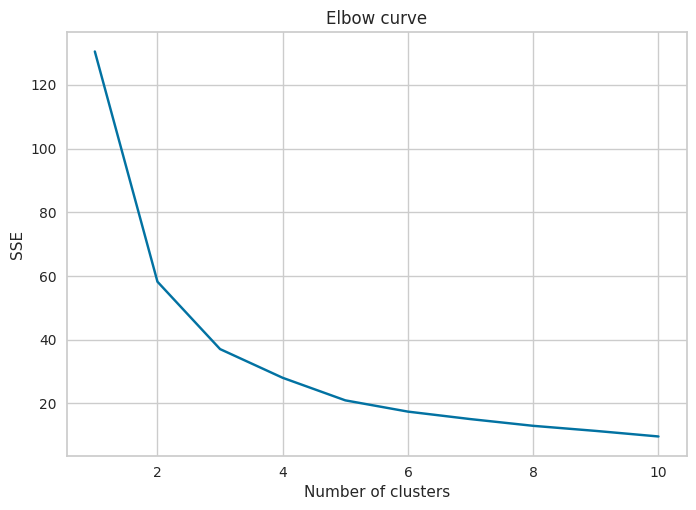

In [70]:
# plot the SSE for each n_clusters
plt.plot(range(1,11),  sse)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow curve')

##### Silhouette Score



Jika ingin mengetahui nilai silhouette saja, tanpa divisualisasikan, maka bisa gunakan [sklearn.metrics.silhouette_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). 
*   X : data yang digunakan untuk melakukan prediksi
*   labels : label cluster

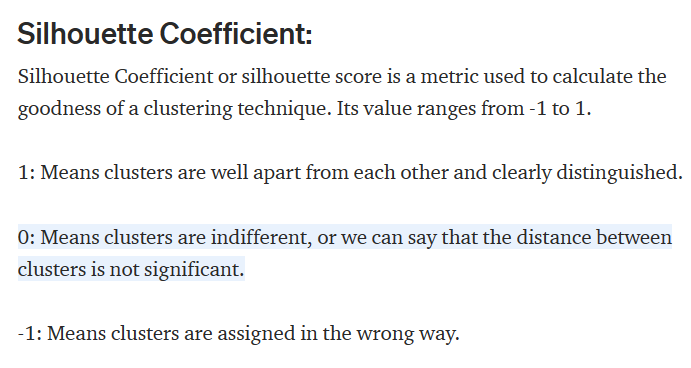

[towardsdatascience: silhouette coefficient](https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c)

In [71]:
n_cluster_list = np.arange(start=2, stop=11, step=1)
silhouette_score_list = []

for cluster in n_cluster_list:
  kmeans_model = KMeans(n_clusters = cluster, n_init=10, random_state=42)
  kmeans_model.fit_transform(X) 

  silhouette = silhouette_score(X, kmeans_model.labels_) # getting silhouette score

  print('Silhouette Score(n_cluster= {0}): {1}'.format(cluster, silhouette))
  silhouette_score_list.append(silhouette)

Silhouette Score(n_cluster= 2): 0.4629549773635977
Silhouette Score(n_cluster= 3): 0.4450525692083638
Silhouette Score(n_cluster= 4): 0.4206583419478651
Silhouette Score(n_cluster= 5): 0.41181523011737703
Silhouette Score(n_cluster= 6): 0.3940131398141253
Silhouette Score(n_cluster= 7): 0.3721654418203221
Silhouette Score(n_cluster= 8): 0.3825506599589951
Silhouette Score(n_cluster= 9): 0.3934201505779464
Silhouette Score(n_cluster= 10): 0.40259824410360334


## Analisis Asosiasi

Pada tutorial ini, kita akan melakukan [Employee Attrition analysis](https://towardsdatascience.com/using-association-rules-with-categorical-data-e984f8bb8ee4) menggunakan *association rule* untuk mengidentifikasi karakteristik karyawan yang tidak mempunyai kecenderungan atrisi (meninggalkan perusahaan).

<details>
<summary>Another example: Market basket analysis</summary>

[market basket analysis](https://gifadn.medium.com/market-basket-analisys-lagi-hehe-dengan-menggunakan-pyhton-d415c02bfcb1)

</details>

In [74]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [75]:
df = pd.read_csv('/content/WA_Fn-UseC_-HR-Employee-Attrition.csv')
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,3,Male,41,4,2,Laboratory Technician,4,Married,2571,12290,4,Y,No,17,3,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,4,Male,42,2,3,Healthcare Representative,1,Married,9991,21457,4,Y,No,15,3,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,2,Male,87,4,2,Manufacturing Director,2,Married,6142,5174,1,Y,Yes,20,4,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,4,Male,63,2,2,Sales Executive,2,Married,5390,13243,2,Y,No,14,3,4,80,0,17,3,2,9,6,0,8


In [76]:
df.shape

(1470, 35)

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

We could see that *some columns are **continuous** data.*

But, **association rule analysis** can **only** work **using categorical data.**

So, how should we handle it?

Discretizing/binning on "Age" column

In [78]:
pd.qcut(df['Age'], q=4).unique().sort_values()

[(17.999, 30.0], (30.0, 36.0], (36.0, 43.0], (43.0, 60.0]]
Categories (4, interval[float64, right]): [(17.999, 30.0] < (30.0, 36.0] < (36.0, 43.0] <
                                           (43.0, 60.0]]

In [79]:
df['Age_Range'] = pd.qcut(df['Age'], q=4, labels=['<=30', '>30 <=36', '>36 <=43', '>43'])

Discretizing/binning on "DistanceFromHome" column

In [80]:
pd.qcut(df['DistanceFromHome'], q=4).unique().sort_values()

[(0.999, 2.0], (2.0, 7.0], (7.0, 14.0], (14.0, 29.0]]
Categories (4, interval[float64, right]): [(0.999, 2.0] < (2.0, 7.0] < (7.0, 14.0] < (14.0, 29.0]]

In [81]:
df['DistanceFromHome_Range'] = pd.qcut(df['DistanceFromHome'], q=4, labels=['<=2', '>2 <=7', '>7 <=14', '>14'])

Discretizing/binning on "HourlyRate" column

In [82]:
pd.qcut(df['HourlyRate'], q=4).unique().sort_values()

[(29.999, 48.0], (48.0, 66.0], (66.0, 83.75], (83.75, 100.0]]
Categories (4, interval[float64, right]): [(29.999, 48.0] < (48.0, 66.0] < (66.0, 83.75] <
                                           (83.75, 100.0]]

In [83]:
df['HourlyRate_Range'] = pd.qcut(df['DistanceFromHome'], q=4, labels=['<=48', '>48 <=66', '>66 <=83.75', '>83.75'])

Remove unused columns

In [84]:
columns = ['Attrition',
          'Age_Range',
          'BusinessTravel',
          'Department',
          'DistanceFromHome_Range',
          'Education',
          'EducationField',
          'EnvironmentSatisfaction',
          'Gender',
          'HourlyRate_Range',
          'JobInvolvement',
          'JobLevel',
          'JobRole',
          'JobSatisfaction',
          'MaritalStatus']

not_used_columns = list(set(df.columns.to_list()) - set(columns))
df.drop(labels=not_used_columns, axis=1, inplace=True)

Transform table into Transaction format

In [85]:
df = pd.get_dummies(df, columns=columns)
df.head()

,Attrition_No,Attrition_Yes,Age_Range_<=30,Age_Range_>30 <=36,Age_Range_>36 <=43,Age_Range_>43,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,DistanceFromHome_Range_<=2,DistanceFromHome_Range_>2 <=7,DistanceFromHome_Range_>7 <=14,DistanceFromHome_Range_>14,Education_1,Education_2,Education_3,Education_4,Education_5,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,EnvironmentSatisfaction_1,EnvironmentSatisfaction_2,EnvironmentSatisfaction_3,EnvironmentSatisfaction_4,Gender_Female,Gender_Male,HourlyRate_Range_<=48,HourlyRate_Range_>48 <=66,HourlyRate_Range_>66 <=83.75,HourlyRate_Range_>83.75,JobInvolvement_1,JobInvolvement_2,JobInvolvement_3,JobInvolvement_4,JobLevel_1,JobLevel_2,JobLevel_3,JobLevel_4,JobLevel_5,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,JobSatisfaction_1,JobSatisfaction_2,JobSatisfaction_3,JobSatisfaction_4,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
3,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
4,1,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


By doing this, we can regard **each row** as a **transaction record** 

Whereas the **items** are the **attributes/columns** (*Attrition_No, Attrition_Yes, Age_Range_<=30, etc.*)

The **itemset** of a transaction record includes {item} where {item}==1.

    Row 1: {Attrition_Yes, Age_Range_>36<=43, BusinessTravel_Travel_Rarely, Department_Sales,  DistanceFromHome_Range_<=2, Education_2, EducationField_LifeSciences, EnvironmentSatisfaction_2, Gender_Female,HourlyRate_Range_<=48, JobInvolvement_3, JobLevel_2, JobRole_SalesExecutive, JobSatisfaction_4, MaritalStatus_Single}

In [86]:
# list of "items"
items = set(df.columns)

print("Total items: {0}\n{1}".format(len(items), items))

Total items: 62
{'JobSatisfaction_4', 'HourlyRate_Range_>83.75', 'JobInvolvement_4', 'JobRole_Manager', 'JobLevel_4', 'Education_5', 'Age_Range_>30 <=36', 'HourlyRate_Range_>48 <=66', 'JobSatisfaction_3', 'JobLevel_5', 'MaritalStatus_Married', 'EnvironmentSatisfaction_2', 'Gender_Female', 'EducationField_Marketing', 'DistanceFromHome_Range_<=2', 'Attrition_No', 'Education_2', 'EducationField_Human Resources', 'EnvironmentSatisfaction_3', 'EducationField_Life Sciences', 'Gender_Male', 'JobInvolvement_2', 'EducationField_Medical', 'JobLevel_3', 'JobRole_Sales Representative', 'JobRole_Sales Executive', 'JobSatisfaction_1', 'Education_4', 'Age_Range_>43', 'JobSatisfaction_2', 'Education_3', 'JobRole_Research Scientist', 'Education_1', 'DistanceFromHome_Range_>2 <=7', 'JobInvolvement_1', 'EnvironmentSatisfaction_1', 'HourlyRate_Range_<=48', 'EducationField_Other', 'JobRole_Human Resources', 'JobRole_Healthcare Representative', 'MaritalStatus_Single', 'Department_Human Resources', 'Age_Rang

In [87]:
# list of "transaction records"
items_array = np.array(list(df.columns))
row_values = df.values

transaction_records = []

for row in row_values:
  itemset = items_array[np.where(row == 1)]
  transaction_records.append(itemset)

print(f'Total transaction records: {len(transaction_records)}')
print('\nFirst 3 transaction records:\n')
transaction_records[:3]

Total transaction records: 1470

First 3 transaction records:



[array(['Attrition_Yes', 'Age_Range_>36 <=43',
        'BusinessTravel_Travel_Rarely', 'Department_Sales',
        'DistanceFromHome_Range_<=2', 'Education_2',
        'EducationField_Life Sciences', 'EnvironmentSatisfaction_2',
        'Gender_Female', 'HourlyRate_Range_<=48', 'JobInvolvement_3',
        'JobLevel_2', 'JobRole_Sales Executive', 'JobSatisfaction_4',
        'MaritalStatus_Single'], dtype='<U33'),
 array(['Attrition_No', 'Age_Range_>43',
        'BusinessTravel_Travel_Frequently',
        'Department_Research & Development',
        'DistanceFromHome_Range_>7 <=14', 'Education_1',
        'EducationField_Life Sciences', 'EnvironmentSatisfaction_3',
        'Gender_Male', 'HourlyRate_Range_>66 <=83.75', 'JobInvolvement_2',
        'JobLevel_2', 'JobRole_Research Scientist', 'JobSatisfaction_2',
        'MaritalStatus_Married'], dtype='<U33'),
 array(['Attrition_Yes', 'Age_Range_>36 <=43',
        'BusinessTravel_Travel_Rarely',
        'Department_Research & Development'

We will analyze <u>NO attrition</u> employees. But first, how many are they?

In [88]:
df['Attrition_No'].value_counts()

1    1233
0     237
Name: Attrition_No, dtype: int64

### Apriori


Dalam melakukan analisa asosiasi menggunakan metode apriori, library yang digunakan adalah **mlxtend** ([apriori](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/), [association_rules](https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/)).

Beberapa paremeter untuk metode **Apriori**:

*   min_support : threshold of minimum support; default = 0.5
      * *for example,* **min_support = 0.1** means that **only results that occurred more than** (0.1 * 1470 records) = **147 times** in our data will be considered
*   max_len : maximum length of the itemsets generated; default = None (no limits)
      * *for example,* **max_len = 4** means that we want itemsets with **no more than 4 items** 

---


Beberapa parameter untuk function **Association rules**:
* metric : menentukan *interestingness measures* (**lift, support, confidence, leverage, conviction, zhangs_metric**) yang ingin digunakan untuk mengevaluasi pola-pola yang ada

* threshold : batas nilai *interestingness measures* minimum yang harus dipenuhi agar suatu *pattern* dapat dikatakan "menarik"

Dengan mengatur parameter function *association rules*, akan lebih mudah dalam menemukan pola yang benar-benar "menarik" atau *insightful*.

<details>
<summary><u>Explanation on different types of interestingness measures</u></summary>


*   'support' is used to measure the **frequency** (often interpreted as significance or importance) **of an itemset** in a database
*   'confidence' is the probability of seeing the consequent in a transaction given that it also contains the antecedent
* 'lift' is commonly used to measure how much more often the antecedent and consequent of a rule A->C occur together than we would expect if they were statistically independent. If A and C are independent, the Lift score will be exactly 1
* 'leverage' computes the difference between the observed frequency of A and C appearing together and the frequency that would be expected if A and C were independent
* A high 'conviction' value means that the consequent is highly depending on the antecedent
</details>


In [89]:
# Apriori param.: Min support & max length of itemset
min_support = 0.1
max_len = 4

# Association rules param.: Metric of interestingness measures & its threshold
metric = 'lift'
min_threshold = 1

# generate association rules using "apriori" approach
frequent_itemsets_apriori = apriori(df, use_colnames=True, min_support= min_support, max_len= max_len)
rules_apriori = association_rules(frequent_itemsets_apriori, metric= metric, min_threshold= min_threshold)

Display **frequent itemsets** (based on Apriori method)

In [90]:
# Membuat kolom baru bernama 'length' untuk melihat panjang itemset
frequent_itemsets_apriori['itemsets_length'] = frequent_itemsets_apriori.itemsets.apply(lambda x: len(x))

# filter-view terhadap itemsets dengan panjang tertentu (specify "filter_length_itemsets")
filter_length_itemsets = max_len 
(frequent_itemsets_apriori[ frequent_itemsets_apriori['itemsets_length'] <= filter_length_itemsets ]
 .sort_values(by='support', ascending=False)
)

,support,itemsets,itemsets_length
0,0.838776,(Attrition_No),1
8,0.709524,(BusinessTravel_Travel_Rarely),1
9,0.653741,(Department_Research & Development),1
52,0.603401,"(Attrition_No, BusinessTravel_Travel_Rarely)",2
27,0.600000,(Gender_Male),1
...,...,...,...
865,0.100000,"(Department_Research & Development, DistanceFr...",4
268,0.100000,"(EducationField_Medical, MaritalStatus_Single)",2
199,0.100000,"(JobSatisfaction_4, Department_Sales)",2
653,0.100000,"(Department_Research & Development, Gender_Mal...",3


Display **association rules** (based on Apriori method)

In [91]:
rules_apriori.head(10).sort_values(by='confidence', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,(Age_Range_>36 <=43),(Attrition_No),0.221088,0.838776,0.201361,0.910769,1.085832,0.015917,1.806826,0.101484
5,(Age_Range_>43),(Attrition_No),0.236054,0.838776,0.207483,0.878963,1.047912,0.009486,1.332021,0.059848
8,(Department_Research & Development),(Attrition_No),0.653741,0.838776,0.563265,0.861602,1.027215,0.014923,1.164938,0.076514
7,(BusinessTravel_Travel_Rarely),(Attrition_No),0.709524,0.838776,0.603401,0.850431,1.013896,0.008270,1.077930,0.047184
1,(Age_Range_>30 <=36),(Attrition_No),0.280272,0.838776,0.235374,0.839806,1.001228,0.000289,1.006432,0.001705
6,(Attrition_No),(BusinessTravel_Travel_Rarely),0.838776,0.709524,0.603401,0.719384,1.013896,0.008270,1.035136,0.085011
9,(Attrition_No),(Department_Research & Development),0.838776,0.653741,0.563265,0.671533,1.027215,0.014923,1.054165,0.164328
0,(Attrition_No),(Age_Range_>30 <=36),0.838776,0.280272,0.235374,0.280616,1.001228,0.000289,1.000479,0.007610
4,(Attrition_No),(Age_Range_>43),0.838776,0.236054,0.207483,0.247364,1.047912,0.009486,1.015027,0.283586
3,(Attrition_No),(Age_Range_>36 <=43),0.838776,0.221088,0.201361,0.240065,1.085832,0.015917,1.024971,0.490293


#### **Filtering only consequents with "Attrition_No"**

In [92]:
'''
Filtering only consequents with Attrition NO
'''

target = '{\'Attrition_No\'}'

results_attrition_no_apriori = (rules_apriori[ rules_apriori['consequents'].astype(str).str.contains(target, na=False) ]
                                .sort_values(by='confidence', ascending=False))

results_attrition_no_apriori.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1091,"(JobSatisfaction_4, JobLevel_2)",(Attrition_No),0.117007,0.838776,0.110884,0.947674,1.129831,0.012742,3.081179,0.130139
636,"(Department_Research & Development, JobLevel_2)",(Attrition_No),0.191156,0.838776,0.180952,0.946619,1.128573,0.020615,3.020272,0.140849
2720,"(Department_Research & Development, JobInvolve...",(Attrition_No),0.111565,0.838776,0.105442,0.945122,1.126788,0.011865,2.937868,0.126651
2082,"(Department_Research & Development, BusinessTr...",(Attrition_No),0.127211,0.838776,0.119728,0.941176,1.122084,0.013027,2.740816,0.124659
2658,"(Department_Research & Development, Gender_Mal...",(Attrition_No),0.112245,0.838776,0.104762,0.933333,1.112733,0.010614,2.418367,0.114122
850,"(JobLevel_2, EducationField_Life Sciences)",(Attrition_No),0.146939,0.838776,0.136054,0.925926,1.103902,0.012806,2.176531,0.110335
382,"(Department_Research & Development, Age_Range_...",(Attrition_No),0.150340,0.838776,0.138776,0.923077,1.100505,0.012674,2.095918,0.107486
723,"(DistanceFromHome_Range_<=2, MaritalStatus_Mar...",(Attrition_No),0.129252,0.838776,0.119048,0.921053,1.098092,0.010634,2.042177,0.102589
2866,"(DistanceFromHome_Range_<=2, MaritalStatus_Mar...",(Attrition_No),0.129252,0.838776,0.119048,0.921053,1.098092,0.010634,2.042177,0.102589
1018,"(MaritalStatus_Married, HourlyRate_Range_<=48)",(Attrition_No),0.129252,0.838776,0.119048,0.921053,1.098092,0.010634,2.042177,0.102589


**Visualize** antecedents-consequents pattern for **NO Attrition** employees

In [93]:
# combine value from column 'antecedents' and 'consequents' into one column
results_attrition_no_apriori['antecedents'] = results_attrition_no_apriori['antecedents'].apply(lambda x: list(x))
results_attrition_no_apriori['consequents'] = results_attrition_no_apriori['consequents'].apply(lambda x: list(x))
results_attrition_no_apriori['antecedents-consequents'] = ('Antecedents: '+results_attrition_no_apriori['antecedents'].astype('str') 
                                                          + ' - ' 
                                                          + 'Consequents: '+results_attrition_no_apriori['consequents'].astype('str'))

In [94]:
# top 5 antecendents-consequents pair
fig = px.bar(results_attrition_no_apriori.head(), 
             x= results_attrition_no_apriori.head()['antecedents-consequents'], 
             y= results_attrition_no_apriori.head()['confidence'], 
             text=results_attrition_no_apriori.head()['confidence'])
fig.update_layout(title_text= "What are the *top* characteristics of NO Attrition employees? (Apriori)")
fig.show()

In [95]:
# bottom 5 antecendents-consequents pair
fig = px.bar(results_attrition_no_apriori.tail(), 
             x= results_attrition_no_apriori.tail()['antecedents-consequents'], 
             y= results_attrition_no_apriori.tail()['confidence'], 
             text= results_attrition_no_apriori.tail()['confidence'])
fig.update_layout(title_text= "What are the *least* characteristics of NO Attrition employees? (Apriori)")
fig.show()

#### **Filtering only consequents with "Attrition_Yes"**

In [96]:
'''
Filtering only consequents with Attrition YES
'''

# Apriori param.: Min support & max length of itemset
min_support = 0.02
max_len = 4

# Association rules param.: Metric of interestingness measures & its threshold
metric = 'lift'
min_threshold = 1

# generate association rules using "apriori" approach
frequent_itemsets_apriori = apriori(df, use_colnames=True, min_support= min_support, max_len= max_len)
rules_apriori = association_rules(frequent_itemsets_apriori, metric= metric, min_threshold= min_threshold)

target = '{\'Attrition_Yes\'}'

results_attrition_yes_apriori = (rules_apriori[rules_apriori['consequents'].astype(str).str.contains(target, na=False) ]
                                 .sort_values(by='confidence', ascending=False))

results_attrition_yes_apriori.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
67293,"(Age_Range_<=30, MaritalStatus_Single, JobLeve...",(Attrition_Yes),0.072789,0.161224,0.033333,0.457944,2.840412,0.021598,1.547396,0.698804
67253,"(JobInvolvement_2, Age_Range_<=30, JobLevel_1)",(Attrition_Yes),0.047619,0.161224,0.021088,0.442857,2.746835,0.013411,1.505495,0.667742
4794,"(BusinessTravel_Travel_Frequently, Age_Range_<...",(Attrition_Yes),0.046939,0.161224,0.020408,0.434783,2.696753,0.012840,1.483987,0.660171
4915,"(BusinessTravel_Travel_Frequently, JobLevel_1)",(Attrition_Yes),0.070748,0.161224,0.030612,0.432692,2.683788,0.019206,1.478520,0.675159
68073,"(JobRole_Sales Representative, Department_Sale...",(Attrition_Yes),0.051701,0.161224,0.021769,0.421053,2.611592,0.013433,1.448794,0.650735
5070,"(Department_Sales, JobLevel_1)",(Attrition_Yes),0.051701,0.161224,0.021769,0.421053,2.611592,0.013433,1.448794,0.650735
5471,"(JobRole_Sales Representative, JobLevel_1)",(Attrition_Yes),0.051701,0.161224,0.021769,0.421053,2.611592,0.013433,1.448794,0.650735
68318,"(MaritalStatus_Single, JobLevel_1, Education_3)",(Attrition_Yes),0.061224,0.161224,0.025170,0.411111,2.549930,0.015299,1.424336,0.647474
5082,"(JobRole_Sales Representative, Department_Sales)",(Attrition_Yes),0.056463,0.161224,0.022449,0.397590,2.466067,0.013346,1.392367,0.630071
102,(JobRole_Sales Representative),(Attrition_Yes),0.056463,0.161224,0.022449,0.397590,2.466067,0.013346,1.392367,0.630071


**Visualize** antecedents-consequents pattern for **YES Attrition** employees

In [97]:
# combine value from column 'antecedents' and 'consequents' into one column
results_attrition_yes_apriori['antecedents'] = results_attrition_yes_apriori['antecedents'].apply(lambda x: list(x))
results_attrition_yes_apriori['consequents'] = results_attrition_yes_apriori['consequents'].apply(lambda x: list(x))
results_attrition_yes_apriori['antecedents-consequents'] = ('Antecedents: '+results_attrition_yes_apriori['antecedents'].astype('str') 
                                                              + ' - ' 
                                                              + 'Consequents: '+results_attrition_yes_apriori['consequents'].astype('str'))

In [98]:
# top 5 antecendents-consequents pair
fig = px.bar(results_attrition_yes_apriori.head(), 
             x= results_attrition_yes_apriori.head()['antecedents-consequents'], 
             y= results_attrition_yes_apriori.head()['confidence'], 
             text= results_attrition_yes_apriori.head()['confidence'])
fig.update_layout(title_text= "What are the *top* characteristics of YES Attrition employees? (Apriori)")
fig.show()

In [99]:
# bottom 5 antecendents-consequents pair
fig = px.bar(results_attrition_yes_apriori.tail(), 
             x= results_attrition_yes_apriori.tail()['antecedents-consequents'], 
             y= results_attrition_yes_apriori.tail()['confidence'], 
             text= results_attrition_yes_apriori.tail()['confidence'])
fig.update_layout(title_text= "What are the *least* characteristics of YES Attrition employees? (Apriori)")
fig.show()

### FP Growth

Analisis asosiasi menggunakan FP Growth juga menggunakan library **mlxtend** ([fpgrowth](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/fpgrowth/), [association_rules](https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/)).

Beberapa parameter untuk **metode FP Growth**:

*   min_support : threshold of minimum support; default = 0.5
*   max_len :  maximum length of the itemsets generated; default = None (no limits)

#### **Filtering only consequents with "Attrition_No"**

In [100]:
'''
Filtering only consequents with Attrition YES
'''

# Apriori param.: Min support & max length of itemset
min_support = 0.1
max_len = 4

# Association rules param.: Metric of interestingness measures & its threshold
metric = 'lift'
min_threshold = 1

# generate association rules using "fpgrowth" approach
frequent_itemsets_fpgrowth = fpgrowth(df, use_colnames=True, min_support= min_support, max_len= max_len)
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric= metric, min_threshold= min_threshold)

target = '{\'Attrition_No\'}'

results_attrition_no_fpgrowth = (rules_fpgrowth[ rules_fpgrowth['consequents'].astype(str).str.contains(target, na=False) ]
                                 .sort_values(by='confidence', ascending=False))

results_attrition_no_fpgrowth.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
633,"(JobSatisfaction_4, JobLevel_2)",(Attrition_No),0.117007,0.838776,0.110884,0.947674,1.129831,0.012742,3.081179,0.130139
466,"(Department_Research & Development, JobLevel_2)",(Attrition_No),0.191156,0.838776,0.180952,0.946619,1.128573,0.020615,3.020272,0.140849
476,"(Department_Research & Development, JobInvolve...",(Attrition_No),0.111565,0.838776,0.105442,0.945122,1.126788,0.011865,2.937868,0.126651
472,"(Department_Research & Development, BusinessTr...",(Attrition_No),0.127211,0.838776,0.119728,0.941176,1.122084,0.013027,2.740816,0.124659
468,"(Department_Research & Development, Gender_Mal...",(Attrition_No),0.112245,0.838776,0.104762,0.933333,1.112733,0.010614,2.418367,0.114122
444,"(JobLevel_2, EducationField_Life Sciences)",(Attrition_No),0.146939,0.838776,0.136054,0.925926,1.103902,0.012806,2.176531,0.110335
1214,"(Department_Research & Development, Age_Range_...",(Attrition_No),0.150340,0.838776,0.138776,0.923077,1.100505,0.012674,2.095918,0.107486
1070,"(DistanceFromHome_Range_<=2, MaritalStatus_Mar...",(Attrition_No),0.129252,0.838776,0.119048,0.921053,1.098092,0.010634,2.042177,0.102589
1064,"(MaritalStatus_Married, HourlyRate_Range_<=48)",(Attrition_No),0.129252,0.838776,0.119048,0.921053,1.098092,0.010634,2.042177,0.102589
827,"(DistanceFromHome_Range_<=2, MaritalStatus_Mar...",(Attrition_No),0.129252,0.838776,0.119048,0.921053,1.098092,0.010634,2.042177,0.102589


**Visualize** antecedents-consequents pattern for **NO Attrition** employees

In [101]:
# combine value from column 'antecedents' and 'consequents' into one column
results_attrition_no_fpgrowth['antecedents'] = results_attrition_no_fpgrowth['antecedents'].apply(lambda x: list(x))
results_attrition_no_fpgrowth['consequents'] = results_attrition_no_fpgrowth['consequents'].apply(lambda x: list(x))
results_attrition_no_fpgrowth['antecedents-consequents'] = ('Antecedents: '+results_attrition_no_fpgrowth['antecedents'].astype('str') 
                                                          + ' - ' 
                                                          + 'Consequents: '+results_attrition_no_fpgrowth['consequents'].astype('str'))

In [102]:
# top 5 antecendents-consequents pair
fig = px.bar(results_attrition_no_fpgrowth.head(), 
             x= results_attrition_no_fpgrowth.head()['antecedents-consequents'], 
             y= results_attrition_no_fpgrowth.head()['confidence'], 
             text=results_attrition_no_fpgrowth.head()['confidence'])
fig.update_layout(title_text= "What are the *top* characteristics of NO Attrition employees? (FP-Growth)")
fig.show()

In [103]:
# bottom 5 antecendents-consequents pair
fig = px.bar(results_attrition_no_fpgrowth.tail(), 
             x= results_attrition_no_fpgrowth.tail()['antecedents-consequents'], 
             y= results_attrition_no_fpgrowth.tail()['confidence'], 
             text= results_attrition_no_fpgrowth.tail()['confidence'])
fig.update_layout(title_text= "What are the *least* characteristics of NO Attrition employees? (FP-Growth)")
fig.show()

#### **Filtering only consequents with "Attrition_Yes"**

In [104]:
'''
Filtering only consequents with Attrition YES
'''

# Apriori param.: Min support & max length of itemset
min_support = 0.02
max_len = 4

# Association rules param.: Metric of interestingness measures & its threshold
metric = 'lift'
min_threshold = 1

# generate association rules using "FP Growth" approach
frequent_itemsets_fpgrowth = apriori(df, use_colnames=True, min_support= min_support, max_len= max_len)
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric= metric, min_threshold= min_threshold)

target = '{\'Attrition_Yes\'}'

results_attrition_yes_fpgrowth = (rules_fpgrowth[ rules_fpgrowth['consequents'].astype(str).str.contains(target, na=False) ]
                                 .sort_values(by='confidence', ascending=False))

results_attrition_yes_fpgrowth.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
67293,"(Age_Range_<=30, MaritalStatus_Single, JobLeve...",(Attrition_Yes),0.072789,0.161224,0.033333,0.457944,2.840412,0.021598,1.547396,0.698804
67253,"(JobInvolvement_2, Age_Range_<=30, JobLevel_1)",(Attrition_Yes),0.047619,0.161224,0.021088,0.442857,2.746835,0.013411,1.505495,0.667742
4794,"(BusinessTravel_Travel_Frequently, Age_Range_<...",(Attrition_Yes),0.046939,0.161224,0.020408,0.434783,2.696753,0.012840,1.483987,0.660171
4915,"(BusinessTravel_Travel_Frequently, JobLevel_1)",(Attrition_Yes),0.070748,0.161224,0.030612,0.432692,2.683788,0.019206,1.478520,0.675159
68073,"(JobRole_Sales Representative, Department_Sale...",(Attrition_Yes),0.051701,0.161224,0.021769,0.421053,2.611592,0.013433,1.448794,0.650735
5070,"(Department_Sales, JobLevel_1)",(Attrition_Yes),0.051701,0.161224,0.021769,0.421053,2.611592,0.013433,1.448794,0.650735
5471,"(JobRole_Sales Representative, JobLevel_1)",(Attrition_Yes),0.051701,0.161224,0.021769,0.421053,2.611592,0.013433,1.448794,0.650735
68318,"(MaritalStatus_Single, JobLevel_1, Education_3)",(Attrition_Yes),0.061224,0.161224,0.025170,0.411111,2.549930,0.015299,1.424336,0.647474
5082,"(JobRole_Sales Representative, Department_Sales)",(Attrition_Yes),0.056463,0.161224,0.022449,0.397590,2.466067,0.013346,1.392367,0.630071
102,(JobRole_Sales Representative),(Attrition_Yes),0.056463,0.161224,0.022449,0.397590,2.466067,0.013346,1.392367,0.630071


**Visualize** antecedents-consequents pattern for **YES Attrition** employees

In [105]:
# combine value from column 'antecedents' and 'consequents' into one column
results_attrition_yes_fpgrowth['antecedents'] = results_attrition_yes_fpgrowth['antecedents'].apply(lambda x: list(x))
results_attrition_yes_fpgrowth['consequents'] = results_attrition_yes_fpgrowth['consequents'].apply(lambda x: list(x))
results_attrition_yes_fpgrowth['antecedents-consequents'] = ('Antecedents: '+results_attrition_yes_fpgrowth['antecedents'].astype('str') 
                                                              + ' - ' 
                                                              + 'Consequents: '+results_attrition_yes_fpgrowth['consequents'].astype('str'))

In [106]:
# top 5 antecendents-consequents pair
fig = px.bar(results_attrition_yes_fpgrowth.head(), 
             x= results_attrition_yes_fpgrowth.head()['antecedents-consequents'], 
             y= results_attrition_yes_fpgrowth.head()['confidence'], 
             text= results_attrition_yes_fpgrowth.head()['confidence'])
fig.update_layout(title_text= "What are the *top* characteristics of YES Attrition employees? (FP-Growth)")
fig.show()

In [107]:
# bottom 5 antecendents-consequents pair
fig = px.bar(results_attrition_yes_fpgrowth.tail(), 
             x= results_attrition_yes_fpgrowth.tail()['antecedents-consequents'], 
             y= results_attrition_yes_fpgrowth.tail()['confidence'], 
             text= results_attrition_yes_fpgrowth.tail()['confidence'])
fig.update_layout(title_text= "What are the *least* characteristics of YES Attrition employees? (FP-Growth)")
fig.show()